## 0.0 Imports

In [1]:
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import datetime 
from matplotlib import pyplot as plt
from scipy import stats as ss
from sklearn.preprocessing import MinMaxScaler, RobustScaler

## 0.1 Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

def crammer_v(df_ref : pd.DataFrame, feature_a : str, feature_b : str) -> float:
    
    cm = pd.crosstab(df_ref[feature_a], df_ref[feature_b]).values

    chi_2 = ss.chi2_contingency(cm)[0]
    r, k = cm.shape
    n = cm.sum()

    fator_chi2 = chi_2/n - ( ((k-1)*(r-1))/(n-1) )
    
    chi2_til = max([0, fator_chi2])
    k_til = k - ( ( (k-1)**2 ) / (n-1) )
    r_til = r - ( ( (r-1)**2 ) / (n-1) )
    
    crammer_2 = chi2_til/(min ([k_til - 1, r_til - 1]) )
    
    crammer = np.sqrt(crammer_2)
    
    return crammer


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv('../Data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../Data/store.csv', low_memory=False)
df_raw = pd.merge(df_sales_raw, df_store_raw, on = 'Store', how = 'left')

## 1.0 Descricao dos dados

### 1.1 Rename Columns

In [4]:
raw_columns = df_raw.columns.values 

snake_case = lambda x: inflection.underscore(x)

new_columns = list(map(snake_case, raw_columns))
df_raw.columns = new_columns
df_raw.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.2 Data Dimensions 

Desta etapa posso descobrir se a quantidade de dados é suficiente para a continuidade do projeto

In [5]:
df_raw.shape


(1017209, 18)

### 1.3 Tipos de dados

In [6]:
df_raw.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [5]:
df1 = df_raw.copy()
df1.loc[:, 'date'] = pd.to_datetime(df1['date'])

### 1.4 Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

#### 1.4.1 - Tratando dados faltantes

Aqui podem ser empregados algoritmos de ML, tecnicas estatisitcas classicas ou até mesmo compreensão do negócio.

Para este tema, inicialmente iremos realizar assumptions sobre o negócio, que levaram os dados a estarem ausentes


In [9]:
df1.competition_distance.max()

75860.0

In [10]:
df1['date'] = pd.to_datetime(df1.date)

# Assumption: Se o dado está nulo, podemos considerar que ou esqueceram de anotar,
# ou não há competidor proximo, para o segundo então o valor pode ser um valor abitrariamente alto
# competition_distance  

df1.loc[df1['competition_distance'].isna(), 'competition_distance'] = df1.competition_distance.max() * 3

# competition_open_since_year    
# Assumption: Aqui estamos pensando na etapa de feature enginnering 
# onde o tempo desde que um competidor foi aberto impacta na quantidade de vendas, de modo que pode-se criar um regime 
# transitorio em que a loja tem suas vendas diminuidas no inicio e posteriomente suas vendas voltam a subir
# aqui a variavel é QUANTO TEMPO tem DESDE QUE O COMPETIDODR FOI ABERTO 
# bem quando esta variavel for calculada para estes casos o retorno será zero. 
# porém TUDO É CICLICO E TUDO pode mudar se necessário. 

df1.loc[df1['competition_open_since_year'].isna(), 'competition_open_since_year'] = \
    df1.loc[df1['competition_open_since_year'].isna(), 'date'].dt.year 

# competition_open_since_month    

df1.loc[df1['competition_open_since_month'].isna(), 'competition_open_since_month'] = \
        df1.loc[df1['competition_open_since_month'].isna(), 'date'].dt.month 

                         
# promo2_since_week               
# Caso o valor seja nulo, siginifica que a loja não aderiu a promo2 
# logo podemos usar a mesma ideia da anterior, uma vez que o "tempo nesta promoção" também será nulo
df1.loc[df1['promo2_since_week'].isna(), 'promo2_since_week'] = \
        df1.loc[df1['promo2_since_week'].isna(), 'date'].dt.isocalendar().week 


# promo2_since_year    
# Caso o valor seja nulo, siginifica que a loja não aderiu a promo2 
# logo podemos usar a mesma ideia da anterior, uma vez que o "tempo nesta promoção" também será nulo
df1.loc[df1['promo2_since_year'].isna(), 'promo2_since_year'] = \
        df1.loc[df1['promo2_since_year'].isna(), 'date'].dt.year 
           
# promo_interval
# Indica os meses em que a promoção reiniciou 
map_month = { 
    1 : 'Jan',
    2 : 'Feb',
    3 : 'Mar',
    4 : 'Apr',
    5 : 'May',
    6 : 'Jun',
    7 : 'Jul',
    8 : 'Aug',
    9 : 'Sep',
    10 : 'Oct',
    11 : 'Nov',
    12 : 'Dec',
}
df1['date_month'] = df1['date'].dt.month.map(map_month)
df1.promo_interval.fillna("0", inplace=True)

df1['is_promo'] = df1.apply(lambda x: 1 if x['date_month'] in str(x['promo_interval']).split(',') else 0, axis = 1)



### 1.6 Change dtypes

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)  
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int) 
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int) 

### 1.7 Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes(include= ['int64', 'float64', 'int32', 'float32'])
cat_attributes = df1.select_dtypes(exclude= ['int64', 'float64', 'int32', 'float32', 'datetime64[ns]'])


#### 1.7.1 Numerical atributes

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
date_month                              object
is_promo                                 int64
dtype: object

In [14]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# Dispersion - std, min, max, range, skew, kurtousis
# skew - score of assimetry of my variable about its mean - how much my variable distribution is away from a normal distribution
# kurtousis - is how much my variable is concentry around the mean , or how much large is the distribuition curve
d1 = pd.DataFrame(num_attributes.apply (np.std) ).T
d2 = pd.DataFrame(num_attributes.apply(max)).T
d3 = pd.DataFrame(num_attributes.apply(min)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T

metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()



In [15]:
metrics.columns = ['Campo', 'Max', 'Min', 'Amplitude', 'Media', 'Mediana', 'STD', 'Skew', 'Kurtousis']
metrics

,Campo,Max,Min,Amplitude,Media,Mediana,STD,Skew,Kurtousis
0,store,1115.0,1.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,7.0,1.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,41551.0,0.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,7388.0,0.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,1.0,0.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,1.0,0.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,1.0,0.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,227580.0,20.0,227560.0,6007.076294,2330.0,13682.728423,11.512969,177.136255
8,competition_open_since_month,12.0,1.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,2015.0,1900.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


#### 1.7.2 - Categorical Atributes

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
date_month        12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

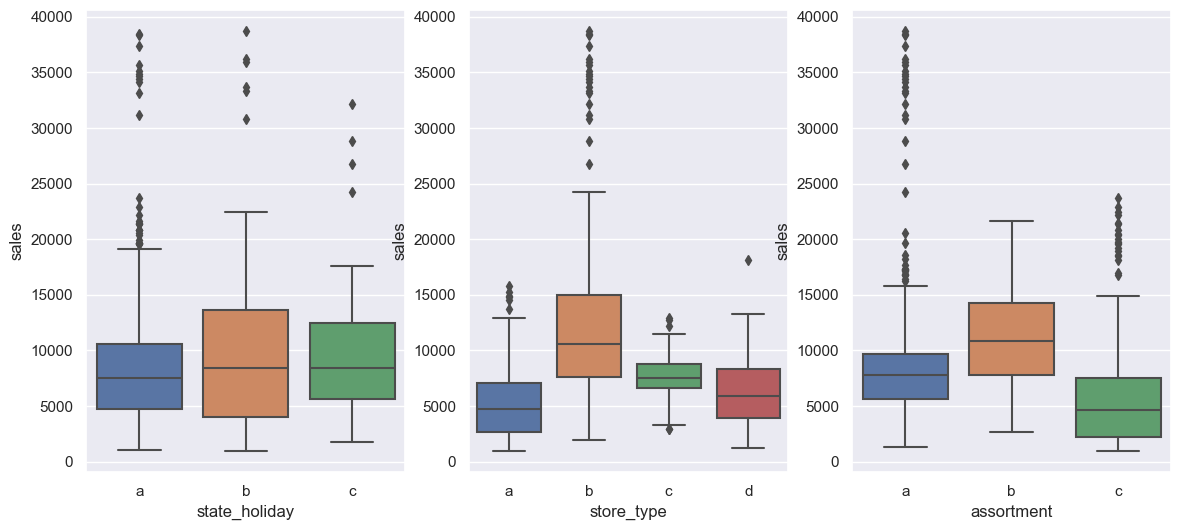

In [18]:
aux1 = df1[(df1.state_holiday != "0") & (df1.sales > 0)]

plt.figure(figsize=(14,6))

plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y = 'sales' , data = aux1.sort_values(by = 'state_holiday') )

plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type', y = 'sales' , data = aux1.sort_values(by = 'store_type') )

plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment', y = 'sales' , data = aux1.sort_values(by = 'assortment'))

**State Holiday:**

    - Feriados municipais, apresentam uma mediana inferior à pascoa e ao natal. 
    - A Pascoa apresenta a menor concentração (maior distribuição) de vendas entre os feriados
    - A pascoa apresenta os maiores valores (comportamento geral, sem outliers) de vendas 
    - O natal possui uma dispersão maior de vendas para vendas mais altas (acima da mediana) (variação é maior)

**Store type:**

    - As lojas do tipo c, apresentam uma concentração muito maior de valor faturado diariamente (contexto mais previsivel)
    - As lojas do tipo "b" apresentam maior dispersão em valor faturado diariamente além de também apresentarem a maior mediana (maior potencial de faturamento)

**Assortments:**

    - Os assortments do tipo b apresentam maior probabilidade de faturarem valores mais elevados, tanto para valores máximos quanto minimos.
    - Os assortments do tipo a apresentam muitos picos no valor faturado, apesar de em geral, faturarem menos que o tipo b (talvez possuem mais ações de promoção, ou as promoções/feriados sao mais efiicientes)
    - O mesmo é valido para os assortments do tipo c, porém com valores um "comportamento padrão" de faturamento mais baixo do que o tipo b, e a. 


## 2 - Exploração dos dados

### 2.1 Feature Enginnering 

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
date_month                              object
is_promo                                 int64
dtype: object

In [21]:
df2 = df1.copy()

# year 
df2['year'] = df2.date.dt.year

# month 
df2['month'] = df2.date.dt.month 

# day
df2['day'] = df2.date.dt.day

# week of year 
df2['week_year'] = df2.date.dt.isocalendar().week

# year-week
df2['year_week'] = df2.date.dt.strftime('%Y-%W')

# competition since 
df2['competion_open_date_temp'] = pd.to_datetime(df2.apply(lambda x:  datetime.date( x['competition_open_since_year'], \
                                                                 x['competition_open_since_month'],1), axis = 1))



df2['competion_since_days'] = (df2['date'] - df2['competion_open_date_temp']).dt.days 
df2['competion_since_month'] = ( (df2['date'] - df2['competion_open_date_temp']).dt.days/30).astype('int') 


# promo since


df2['promo2_since_year_week_temp'] = (df2.apply(lambda x: str(x['promo2_since_year']) + '-' + str(x['promo2_since_week']), axis = 1))


df2['promo2_since'] = df2['promo2_since_year_week_temp'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))

df2['promo2_time_week'] = ( ( df2['date'] - df2['promo2_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# assortment 
assortment_map = {
    'a' : 'basic',
    'b' : 'extra',
    'c' : 'etended'
}

df2.loc[:,'assortment'] = df2['assortment'].apply(lambda x: assortment_map[x])

# state holiday

state_holiday_map = {
    'a' : 'public_holiday',
    'b' : 'easter_holiday',
    'c' : 'christmas',
    '0' : 'regular_day'
}

df2.loc[:, 'state_holiday'] = df2.state_holiday.apply(lambda x: state_holiday_map[x])


## 3 - Filtragem de variáveis

In [23]:
df3 = df2.copy()

### Preliminares


#### Motivação

##### Restrições do negócio
        (Pense sempre nas restrições de negócio nesta estapa)
    


Uma das principais motivações para a filtragem de varíaveis se da devido as restrições do negócio. 
    Muitas vezes, o evento que está sendo modelado, no momento de sua predição (olhando para quando o algoritmo estiver rodando em produção) não possuíra todas as variaveis que eu consigo coletar ao longo da analise. Por exemplo>:

        - Estou predizendo a venda de produtos em minha empresa, e noto que, o valor do desconto, impacta muito fortemente na venda do produto ou não. Meu modelo irá tentar prever as vendas, porém no momento em que a venda esta em fase de negociação (fase em que o modelo deverá realizar as predições) não sou capaz de saber o valor do desconto, ou seja, essa variavel não estará disponivel em produção devido a forma em que o processo é executado, por isso , não faria sentido consdierar essa variavel. 

**Uma outra é interesse... posso estar interessado em uma determinada categoria que gere maior impacto**

##### Modelagem estatistica
    


Essa motivação se da devido a capacidade que um conjunto de variaveis tem de realizar meu modelo performar melhor

### Restrição de Linhas

In [24]:
# "Open: Quando 0 o faturamento sempre será zero, não há ganho de conhecimento"
# 'sales' Deve ser maior que zero, pois quando zero, não há faturamento - sem ganho de conhecimento
df3 = df3[(df3.open != 0) & (df3.sales) > 0]

### Restrição de colunas 

In [25]:
# 'customers' - 'Não há possibilidade de haver o numero de clientes/loja/dia antes que o dia ocorra'
# Open agora somente possui o valor 1 
# Demais colunas temporarias para derivação de features

cols_drop = ['customers', 'open', 'competion_open_date_temp', 'promo2_since_year_week_temp']

df3 = df3.drop(cols_drop, axis= 1)
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'promo_interval',
       'date_month', 'is_promo', 'year', 'month', 'day', 'week_year',
       'year_week', 'competion_since_days', 'competion_since_month',
       'promo2_since', 'promo2_time_week'],
      dtype='object')

In [26]:
df3.to_csv('./dfs/df_EDA.csv', sep = ';', index_label = False, index = False)

## 4.0 - EDA

### 4.0.1 - Hipoteses

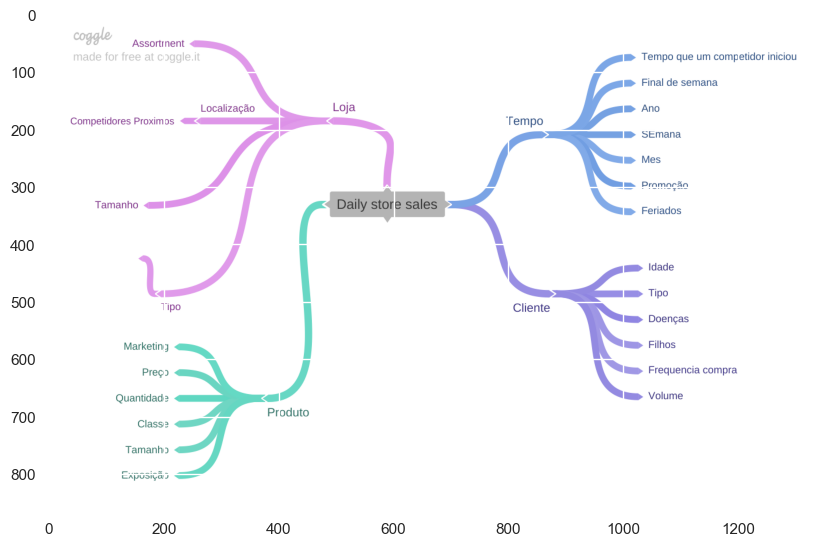

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np 


img = Image.open('./Data/Daily_store_sales.png')
imag_arr = np.array(img)

plt.figure(figsize = (10,12))
plt.imshow(imag_arr)

#### Loja

1. Quanto maior o meu assortment mais vendas a minha loja tem
2. Quanto mais distante os competidores, mais vendas a minha loja possuí 
3. Quanto maior a minha loja, mais vendas eu tenho 
4. Lojas com promoções mais agressivas vendam mais 
5. Lojas com mais dias de promoção vendem mais 
6. Lojas com mais promoções consecutivas vendem mais 

#### Tempo

1. Quanto mais tempo existe desde a abertura do meu competidor mais próximo, maior o faturamento.
2. Quanto mais tempo se passa desde a abertura do competidor, maior o faturamento  
3. Aos finais de semana, as compras são menores 
4. Aos feriados de natal e pascoa as lojas vendem mais  
5. No segundo semestre de cada ano as lojas vendem mais
6. No ultimo trimestre as lojas vendem mais 
7. Lojas vendem mais após o dia 10 de cada mes 
8. Lojas deveriam vender menos durante os feriados escolares


#### Produto

1. Quanto mais marketing no produto, mais eu vendo o produto
2. Quanto menor o preço do meu produto, maior a quatnidad de vendas
3. Existem classes de produtos que vendem mais que outras 
4. Produtos maiores geram maior faturamento
5. Produtos mais expostos , geram maior faturamento


#### Cliente


1. Clientes mais velhos, compram mais 
2. Clientes mais doentes compram mais 
3. Clientes com mais filhos compram mais 
4. 20% dos clientes geram 80% da receita 

### Priorização das hipóteses

1. Quanto maior o meu assortment mais vendas a minha loja tem
2. Quanto mais distante os competidores, mais vendas a minha loja possuí 
4. Lojas com promoções mais agressivas vendam mais 
5. Lojas com mais dias de promoção vendem mais 
6. Lojas com mais promoções consecutivas vendem mais 

==========================================================

1. Quanto mais tempo existe desde a abertura do meu competidor mais próximo, maior o faturamento.
2. Quanto mais tempo se passa desde a abertura do competidor, maior o faturamento  
3. Aos finais de semana, as compras são menores 
4. Aos feriados de natal e pascoa as lojas vendem mais  
6. Lojas vendem mais após o dia 10 de cada mes 
7. Lojas deveriam vender menos durante os feriados escolares


In [6]:
df4 = df3.copy()


NameError: name 'df3' is not defined

### 4.1 - Analise Univariada

#### 4.1.1 - Response Variable

<Axes: xlabel='sales', ylabel='Count'>

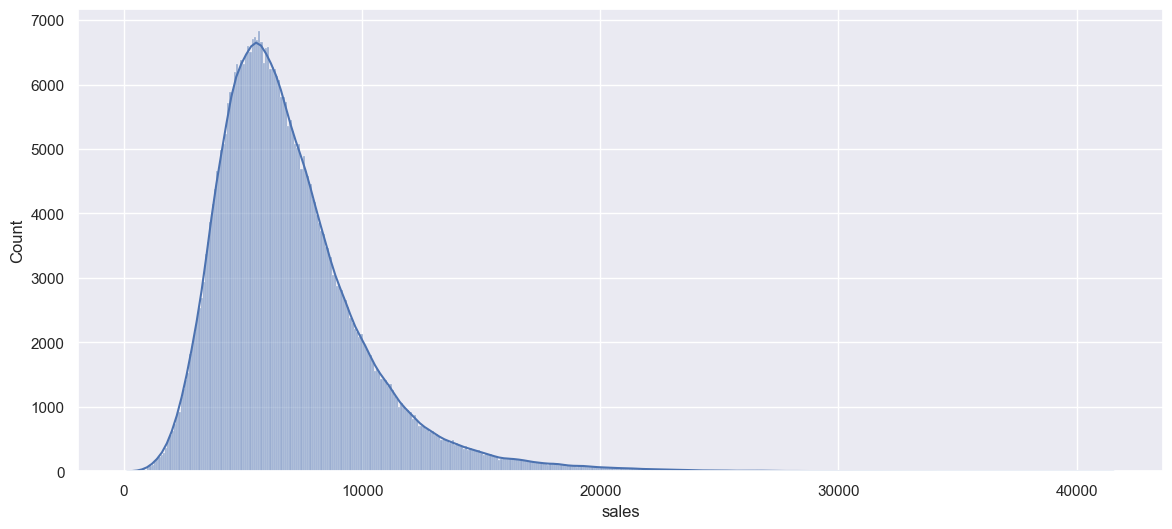

In [27]:
plt.figure(figsize=(14,6))
sns.histplot(df4.sales, kde=True )

#### 4.1.2 - Numerical Variable

C:\Users\ricar\AppData\Local\Temp\ipykernel_17772\2422763952.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  num_attributes.hist(bins= 25, ax =  axs);


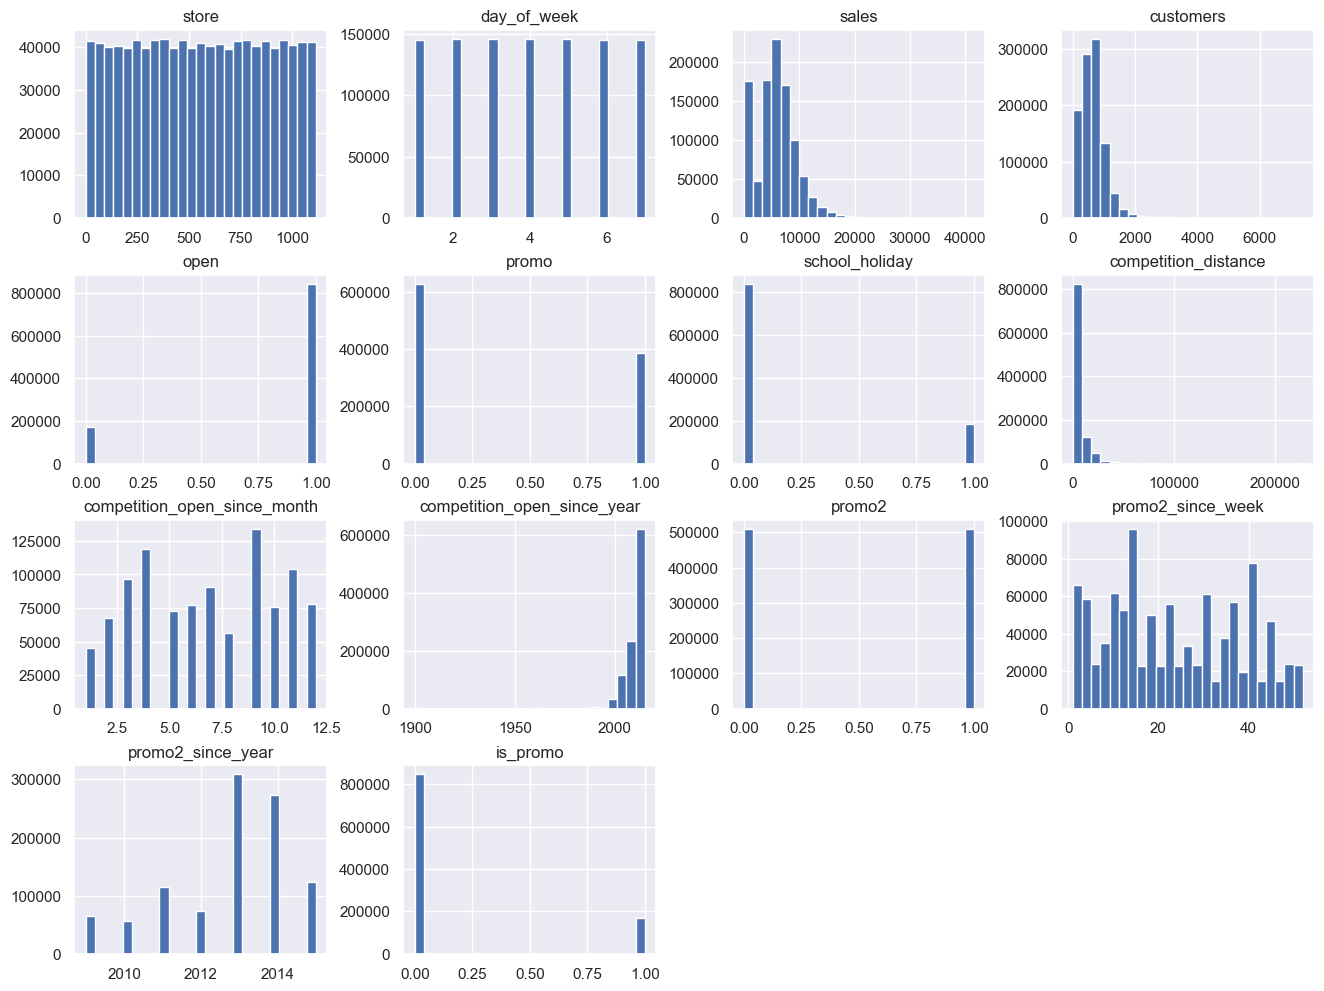

In [28]:
#num_attributes  = df4.select_dtypes(['int32','int64', 'float32', 'float64'])

fig, axs = plt.subplots(figsize=(16,12))
num_attributes.hist(bins= 25, ax =  axs);



#### 4.1.3 - Variaveis CAtegoricas

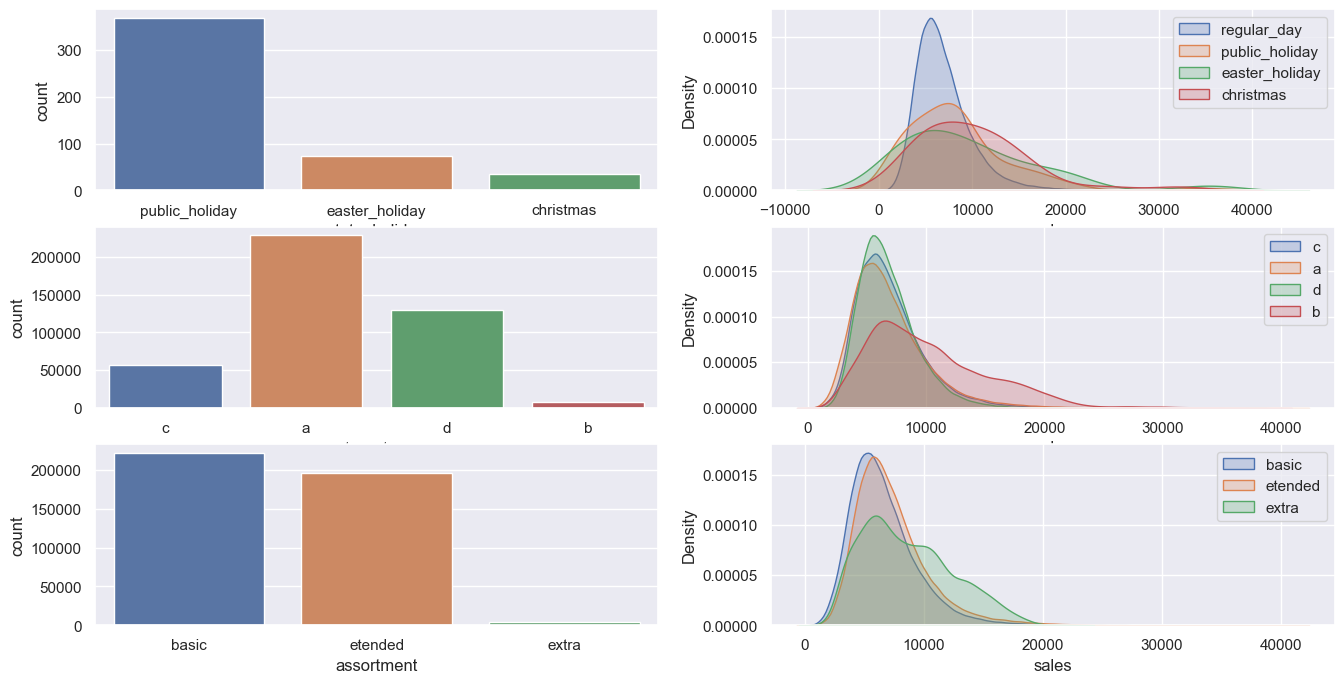

In [30]:
# Feriados 

feriados = df4.state_holiday.unique()
plt.figure(figsize=(16,8))


plt.subplot(3,2,1)
a = df4[df4.state_holiday != 'regular_day']

sns.countplot(a, x = 'state_holiday')

plt.subplot(3,2,2)

for holiday in feriados:
    sns.kdeplot(df4[df4['state_holiday'] == holiday]['sales'], label = holiday, fill = True)
plt.legend()


# Tipos de loja
plt.subplot(3,2,3)
sns.countplot(df4, x = 'store_type')

plt.subplot(3,2,4)
store_types = df4.store_type.unique()

for store in store_types:
    sns.kdeplot(df4[df4['store_type'] == store]['sales'], label = store, fill = True)
plt.legend()

# Assortment
plt.subplot(3,2,5)
sns.countplot(df4, x = 'assortment')

plt.subplot(3,2,6)
assortments = df4.assortment.unique()
for assortment in assortments:
    sns.kdeplot(df4[df4['assortment'] == assortment]['sales'], label = assortment, fill = True)

plt.legend()



**Feriados:**

    - Os feriados apresentam maior probabilidade de terem vendas de valor mais elevado.
    - O valor das vendas em dias comuns é mais previsivel, pois este possui uma maior concentração em uma determinada faixa de valores. 
    - Os valores de vendas no natal e na pasccoa sao bastante similares, com outliers mais extremos para a pascoa, e uma maior "consistencia" em valores maiores para o natal 
    -- public holiday, apresenta um comporatmento um pouco mais centrado (previsivvel) com valores um pouco mais altos que dias normais porém mais baixos que os demais feriados

    **Logo, as variáveis assortment, store_type e state_holiday, geram algum tipo de ganho de conhecimento para o comportamento da variavel predita: sakes**

**Store type:**

    - Temos mais lojas do tipo e menos do tipo b. 
    - Lojas do tipo , a, c e d apresentam um padrão de valor de venda muito similar
    - Lojas do tipo b, apresentam um valor de venda mais elevado

**Assortment:**

    - Há 3 tipos de assortment, o basic e estended, apresentam quantidades muito proximas na amostra
    - O tipo extra, apreenta o padrão de consumo mais elevado(valores mais altos) e menor quantidade 

### 4.2 Análise bivariada 

#### H1. Assortments maiores, são responsáveis por mais vendas no total geral


<Axes: xlabel='assortment', ylabel='sales'>

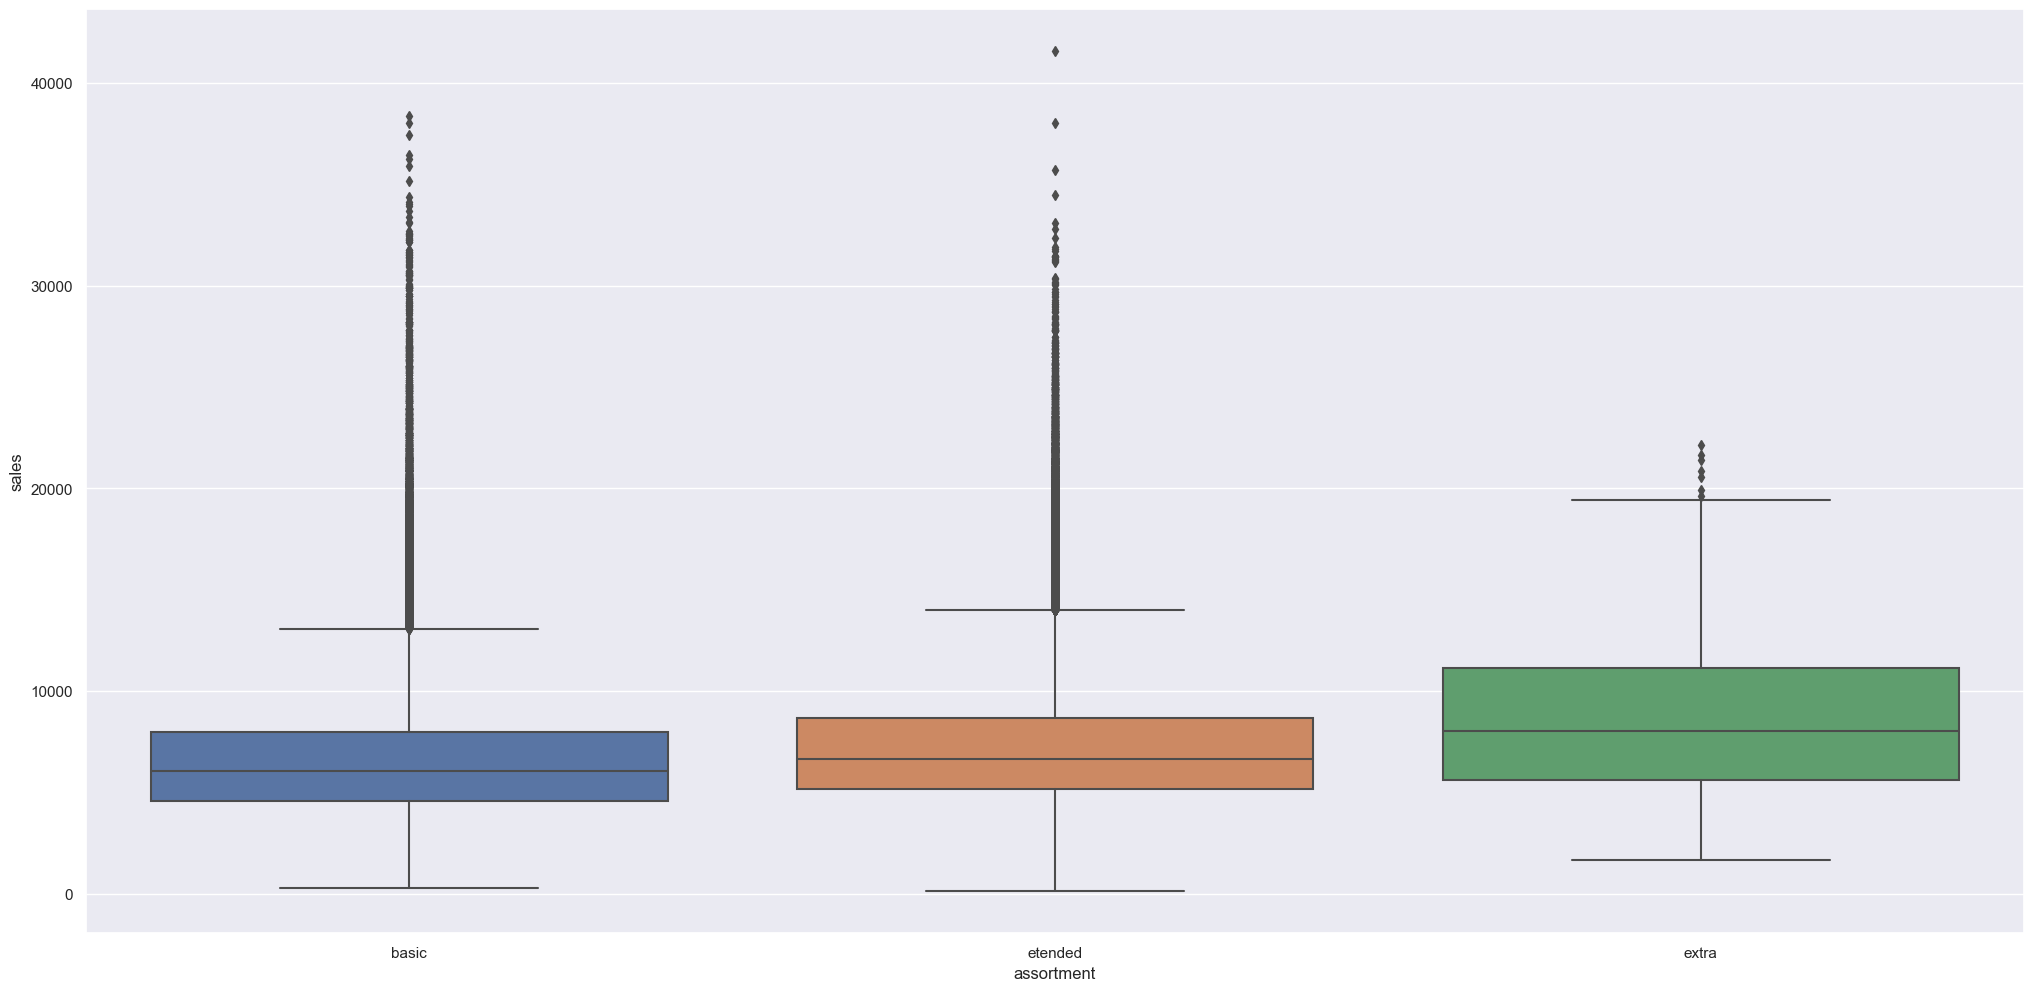

In [31]:
sns.boxplot(x = 'assortment', y = 'sales', data = df4)

In [32]:
assortments = df4.assortment.unique()
def descriptive_Statistics(field, df, categories):
    medias = []
    stds = []
    medianas = []
    for item in categories:
        medias.append(df[df[field] == item]['sales'].mean())
        stds.append(df[df[field] == item]['sales'].std())
        medianas.append(df[df[field] == item]['sales'].median())
    
    df_final = pd.DataFrame(index = categories)
    df_final['media'] = medias
    df_final['mediana'] = medianas 
    df_final['std'] = stds

    return df_final 

estatisicas_assortment = descriptive_Statistics('assortment', df4, df4.assortment.unique().tolist())
estatisicas_assortment

,media,mediana,std
basic,6621.808402,6079.0,2979.600213
etended,7291.458990,6669.0,3172.347692
extra,8631.571010,8048.0,3814.260448


<Axes: xlabel='assortment', ylabel='sales'>

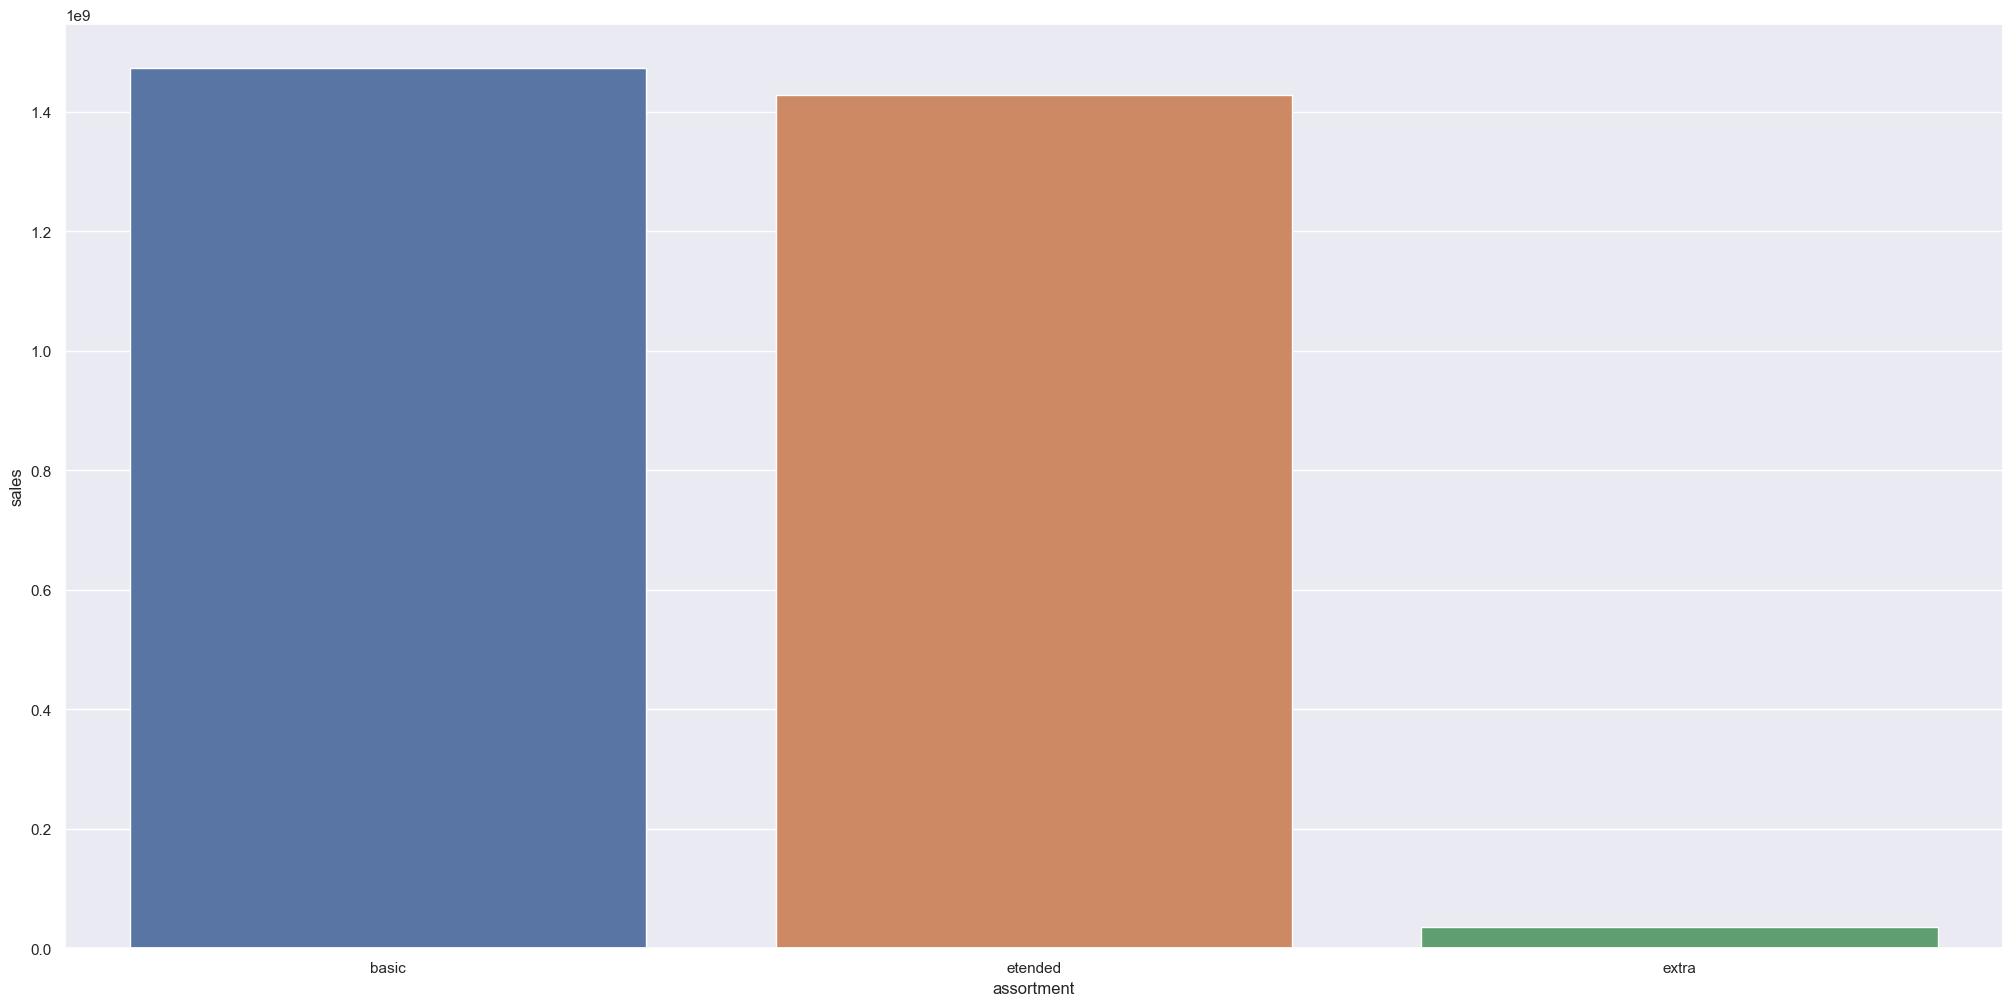

In [33]:
sales_per_assortment = df4.groupby('assortment').agg({'sales' : 'sum'}).reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = sales_per_assortment)

**H1 = Falsa:**

Assortments maiores, não representam mais vendas que os demais assortments na minha base. 

#### H2. Quanto mais distante os competidores, mais vendas a minha loja possuí 
**H2: Falsa**
Não há correlação entre a variavel distancia do competidor, e valor da venda, ou seja uma não impacta na outra, nem positiva, nem negativamente

<Axes: xlabel='competition_distance', ylabel='sales'>

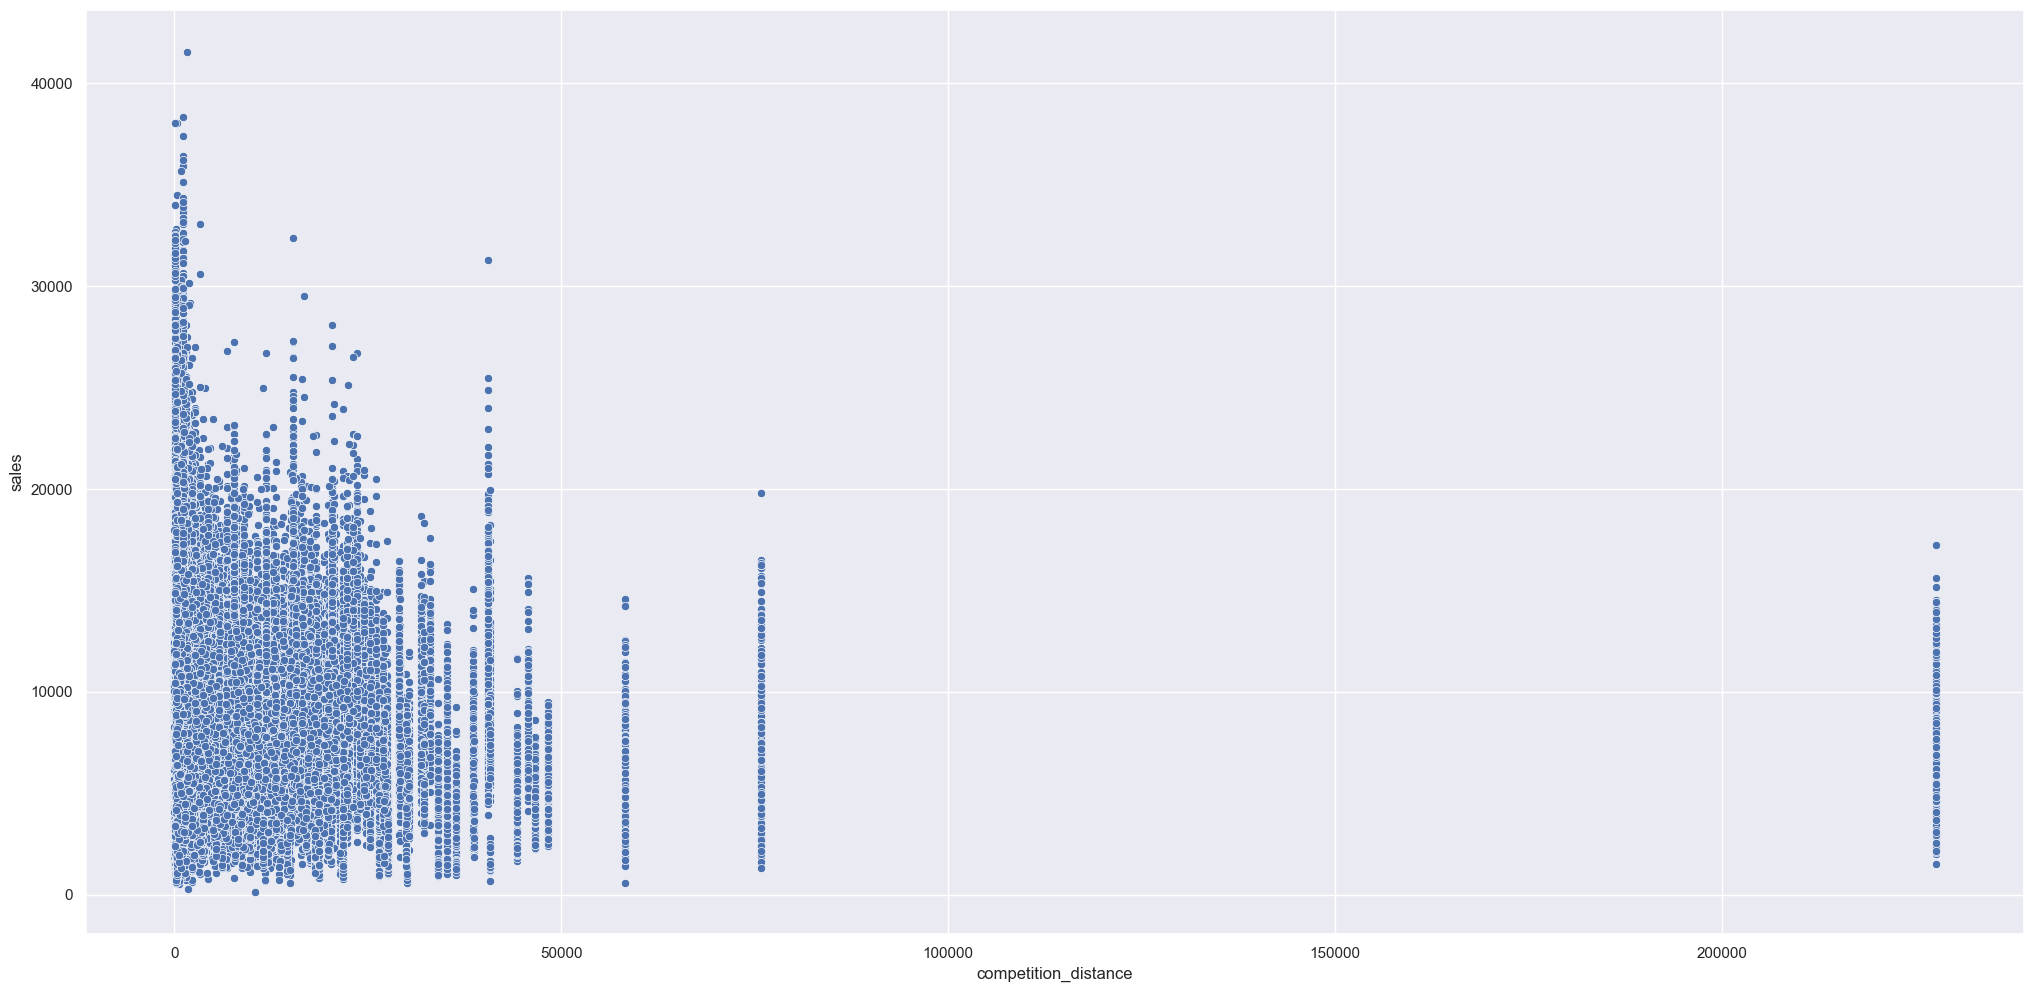

In [34]:
sns.scatterplot(x = 'competition_distance', y = 'sales', data = df4)

In [35]:
df4[['competition_distance', 'sales']].corr('spearman')

,competition_distance,sales
competition_distance,1.000000,-0.039448
sales,-0.039448,1.000000


In [36]:
df4.competition_distance.max()

227580.0

In [37]:
bins = list(np.arange(0,20000 + 1000, 1000))
aux_4_2 = df4.copy()
aux_4_2['competition_distance_binned'] = pd.cut(aux_4_2['competition_distance'], bins)

aux_4_2_gp = aux_4_2[['competition_distance_binned', 'sales', 'store']].groupby('competition_distance_binned').agg({
                                                                                            'sales': ['sum', 'mean', 'median', 'std'], 
                                                                                            'store': 'count' }).reset_index()                                                                                                  
aux_4_2_gp

competition_distance_binned      sales                                     store
                                      sum         mean  median          std   count
0                    (0, 1000]  916128601  7304.543977  6513.0  3583.866042  125419
1                 (1000, 2000]  461156897  7078.495403  6353.0  3469.001096   65149
2                 (2000, 3000]  304295838  6609.953906  6160.0  2680.996241   46036
3                 (3000, 4000]  189894142  6357.778961  5909.0  2469.645309   29868
4                 (4000, 5000]  161920021  7207.657289  6809.0  2474.032137   22465
5                 (5000, 6000]  108431217  6622.562573  6235.0  2472.980823   16373
6                 (6000, 7000]   84096395  6467.460971  6185.0  2509.471528   13003
7                 (7000, 8000]   67329598  6951.228371  6357.0  2853.756733    9686
8                 (8000, 9000]   90656270  7049.476672  6619.0  2577.696300   12860
9                (9000, 10000]   60322643  6620.858632  6311.0  2210.523540    9111
10              (10000, 11000]   38305564  6820.791311  6548.0  2244.460453    5616
11              (11000, 12000]   29228439  6888.625737  6211.0  3046.561686    4243
12              (12000, 13000]   27813636  6800.400000  6474.0  2509.236592    4090
13              (13000, 14000]   37898573  6256.987453  5807.0  2496.485669    6057
14              (14000, 15000]   29602516  6460.610214  6247.0  2772.173484    4582
15              (15000, 16000]   40728900  7681.799321  6991.0  3134.547876    5302
16              (16000, 17000]   35440964  7268.450369  6991.0  2722.665991    4876
17              (17000, 18000]   32416404  6830.257901  6452.0  2383.159951    4746
18              (18000, 19000]   40031903  5943.860876  5677.0  2554.177109    6735
19              (19000, 20000]   19175032  6584.832418  6303.0  2408.238946    2912

In [38]:
aux_4_2_gp[['sum', 'mean', 'median', 'std']] = aux_4_2_gp['sales']
aux_4_2_gp['lojas'] = aux_4_2_gp['store']

In [39]:
aux_4_2_gp.drop('sales', axis = 1, inplace = True)
aux_4_2_gp.drop('store', axis = 1, inplace = True)


C:\Users\ricar\AppData\Local\Temp\ipykernel_17772\908355986.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  aux_4_2_gp.drop('sales', axis = 1, inplace = True)
C:\Users\ricar\AppData\Local\Temp\ipykernel_17772\908355986.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  aux_4_2_gp.drop('store', axis = 1, inplace = True)


<Axes: xlabel='competition_distance_binned', ylabel='median'>

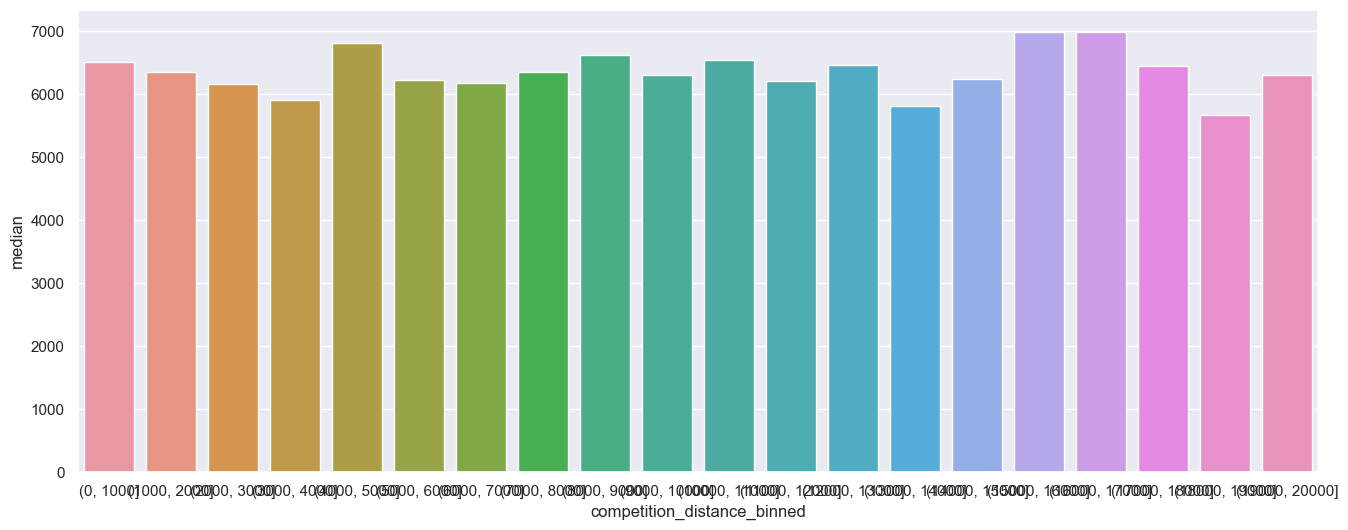

In [40]:
aux_4_2_gp_1 = aux_4_2_gp.copy()
aux_4_2_gp_1 = aux_4_2_gp_1.dropna()
plt.figure(figsize = (16,6))
sns.barplot(y = 'median', x ='competition_distance_binned', data =aux_4_2_gp_1)

**H2: Falsa**
Não há correlação entre a variavel distancia do competidor, e valor da venda, ou seja uma não impacta na outra, nem positiva, nem negativamente

#### H3. Lojas com competidores a mais tempo, vendem mais 

**Hipotese é falsa.** 
Lojas com competidores a mais tempo não vendem mais. 

Porém, lojas com competidores próximos de abrirem vendem mais

Lojas com competidores há muito tempo, vendem menos que lojas com competidores há menos tempo. 

Pode ser que, os competidores abriram antes das lojas da companhia, sendo então, a companhia a lutar pelo marketshare da região, e não o contrario, sendo este um possível motivo para esse comportamento

In [42]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'promo_interval',
       'date_month', 'is_promo', 'year', 'month', 'day', 'week_year',
       'year_week', 'competion_since_days', 'competion_since_month',
       'promo2_since', 'promo2_time_week'],
      dtype='object')

In [43]:
aux1  = df4.groupby(['competion_since_month']).agg({'sales' : 'mean'}).reset_index()
aux1 = aux1.loc[(aux1.competion_since_month < 60) & (aux1.competion_since_month > -12)]
aux1 = aux1.loc[aux1.competion_since_month != 0]
aux1.head(10)

,competion_since_month,sales
20,-11,7129.436178
21,-10,7068.664756
22,-9,7184.660303
23,-8,7202.831325
24,-7,7332.075152
25,-6,7412.509561
26,-5,7378.573840
27,-4,7423.801882
28,-3,7700.332008
29,-2,7449.856504


<Axes: xlabel='competion_since_month', ylabel='sales'>

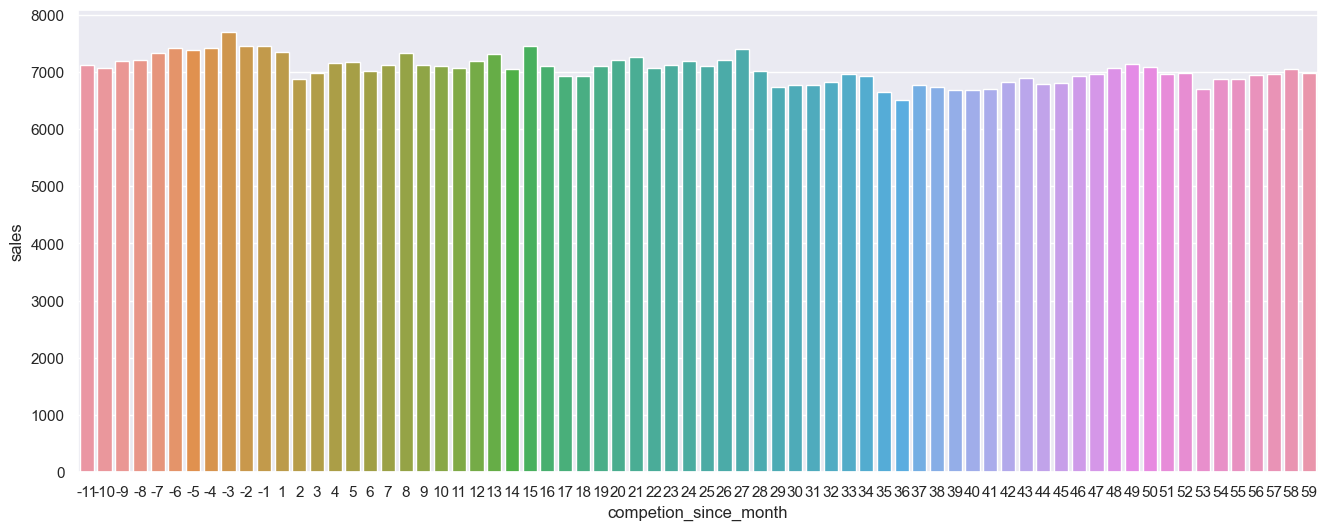

In [44]:
plt.figure(figsize = (16,6))

sns.barplot(x = 'competion_since_month', y = 'sales', data = aux1)
#sns.lineplot(x = 'competion_since_month', y = '')

In [45]:
aux1.rolling(window=3).mean().head()

,competion_since_month,sales
20,NaN,NaN
21,NaN,NaN
22,-10.000000,7127.587079
23,-9.000000,7152.052128
24,-8.000000,7239.855593
25,-7.000000,7315.805346
26,-6.000000,7374.386184
27,-5.000000,7404.961761
28,-4.000000,7500.902576
29,-3.000000,7524.663465


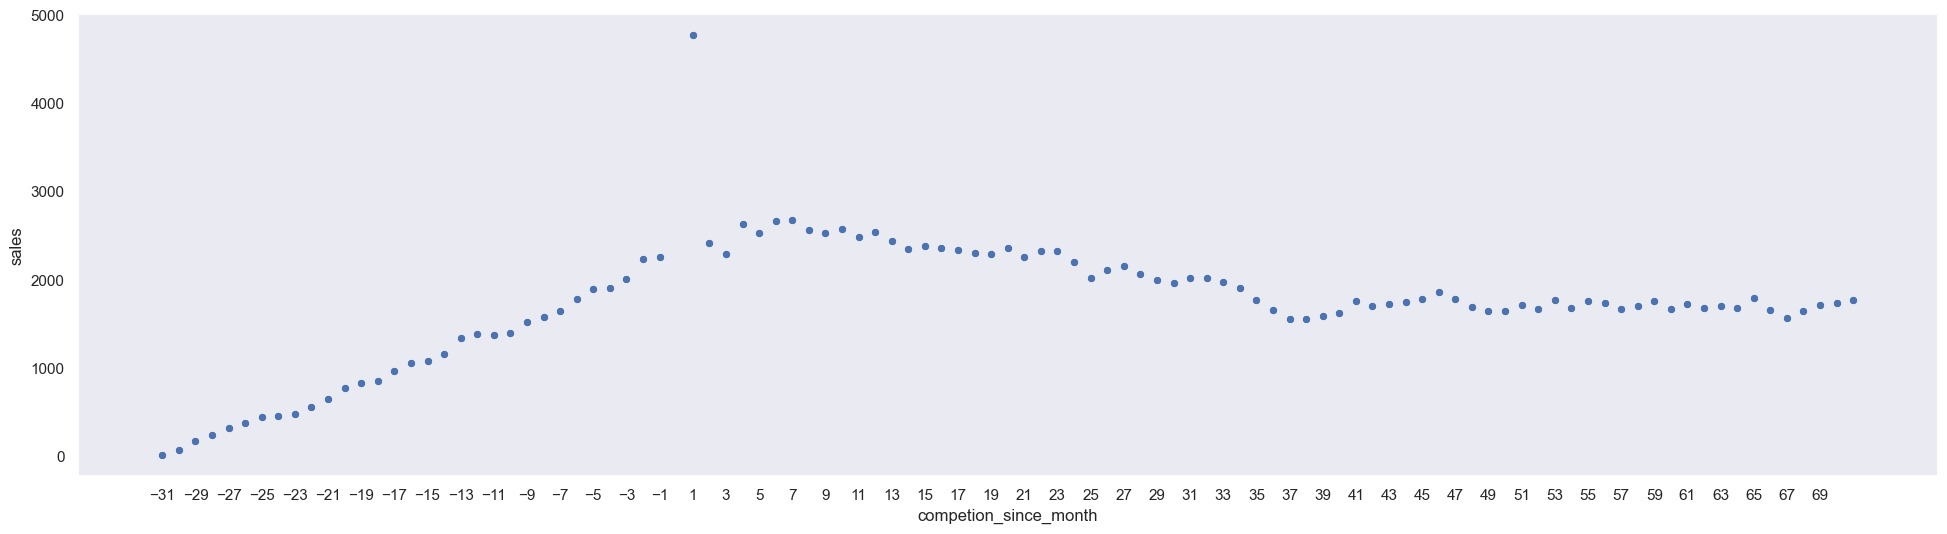

In [46]:
aux1  = df4.groupby(['competion_since_month']).agg({'sales' : 'count'}).reset_index()

aux1 = aux1.loc[(aux1.competion_since_month < 72)]
aux1 = aux1.loc[aux1.competion_since_month != 0]
plt.figure(figsize = (24,6))
sns.scatterplot(x = 'competion_since_month', y = 'sales', data = aux1)
plt.grid()
plt.xticks(np.arange(aux1.competion_since_month.min(), aux1.competion_since_month.max(),2));


In [47]:
aux1[aux1.sales == aux1.sales.max()]

,competion_since_month,sales
32,1,4776


In [48]:
aux1.iloc[32:46]

,competion_since_month,sales
33,2,2414
34,3,2291
35,4,2635
36,5,2536
37,6,2665
38,7,2676
39,8,2570
40,9,2537
41,10,2580
42,11,2483


##### Média

<Axes: xlabel='competion_since_month', ylabel='sales'>

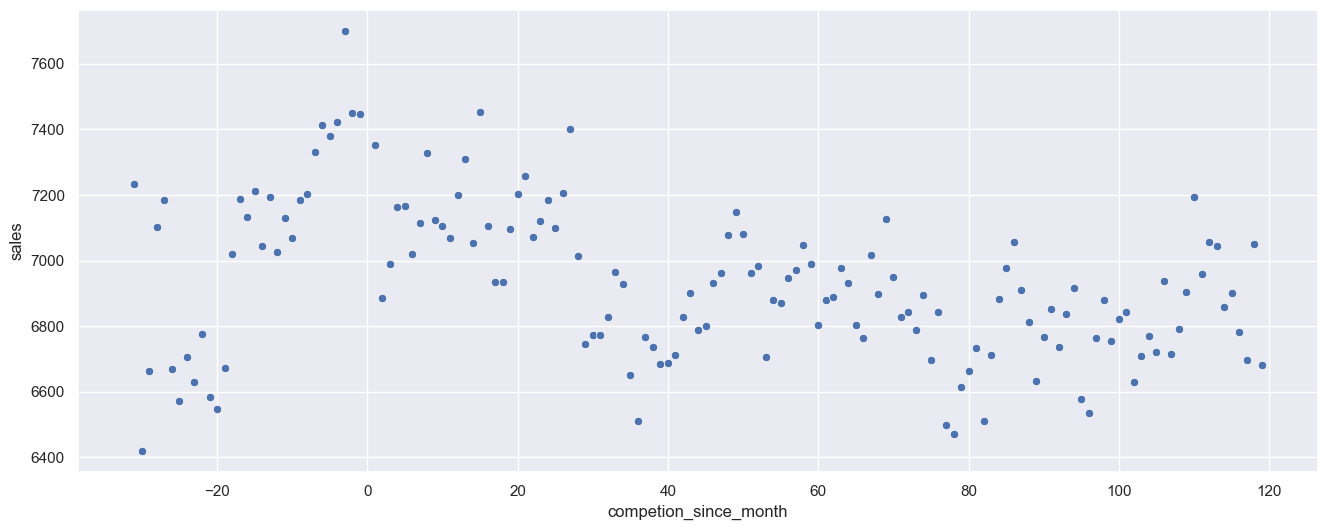

In [49]:
aux1  = df4.groupby(['competion_since_month']).agg({'sales' : 'mean'}).reset_index()

aux1 = aux1.loc[(aux1.competion_since_month < 120)]
aux1 = aux1.loc[aux1.competion_since_month != 0]
plt.figure(figsize = (16,6))
sns.scatterplot(x = 'competion_since_month', y = 'sales', data = aux1)


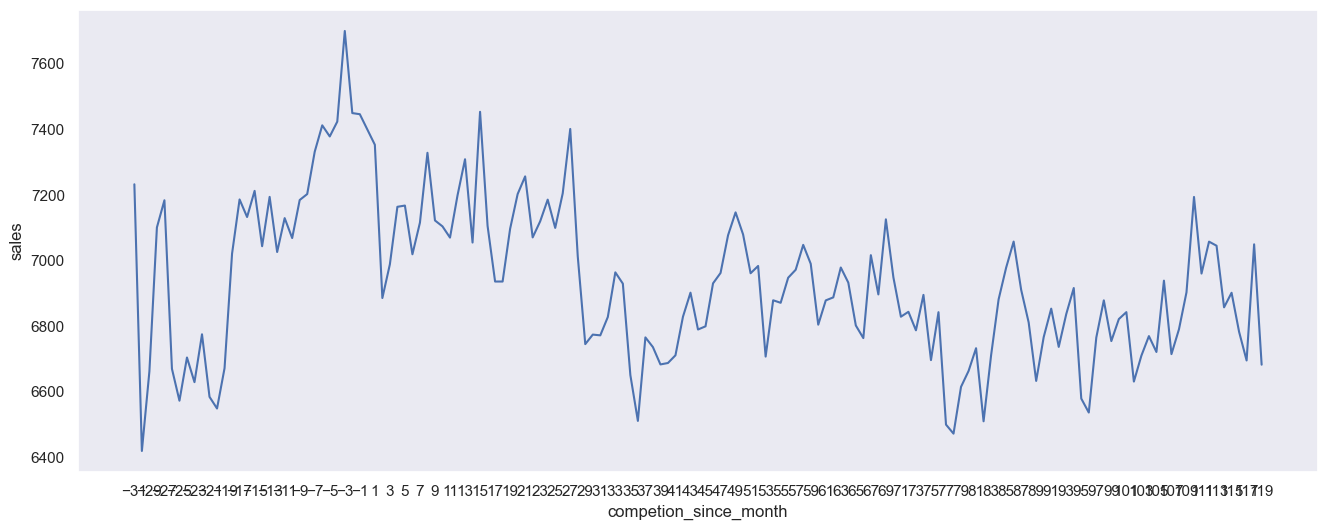

In [50]:
plt.figure(figsize = (16,6))

sns.lineplot(x = 'competion_since_month', y = 'sales', data = aux1)
num_ticks = 30

# Configurando os ticks no eixo x
plt.grid()
plt.xticks(np.arange(aux1.competion_since_month.min(), aux1.competion_since_month.max().max()+1,2));



##### Mediana

<Axes: xlabel='competion_since_month', ylabel='sales'>

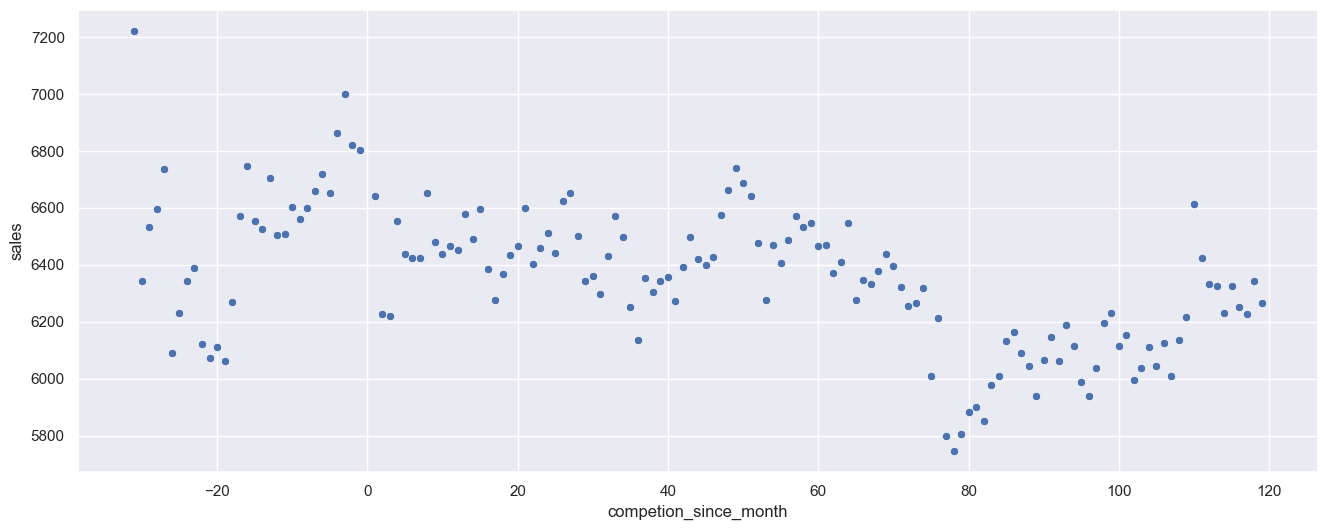

In [51]:
aux1  = df4.groupby(['competion_since_month']).agg({'sales' : 'median'}).reset_index()

aux1 = aux1.loc[(aux1.competion_since_month < 120)]
aux1 = aux1.loc[aux1.competion_since_month != 0]
auxmediana = aux1 
plt.figure(figsize = (16,6))
sns.scatterplot(x = 'competion_since_month', y = 'sales', data = aux1)


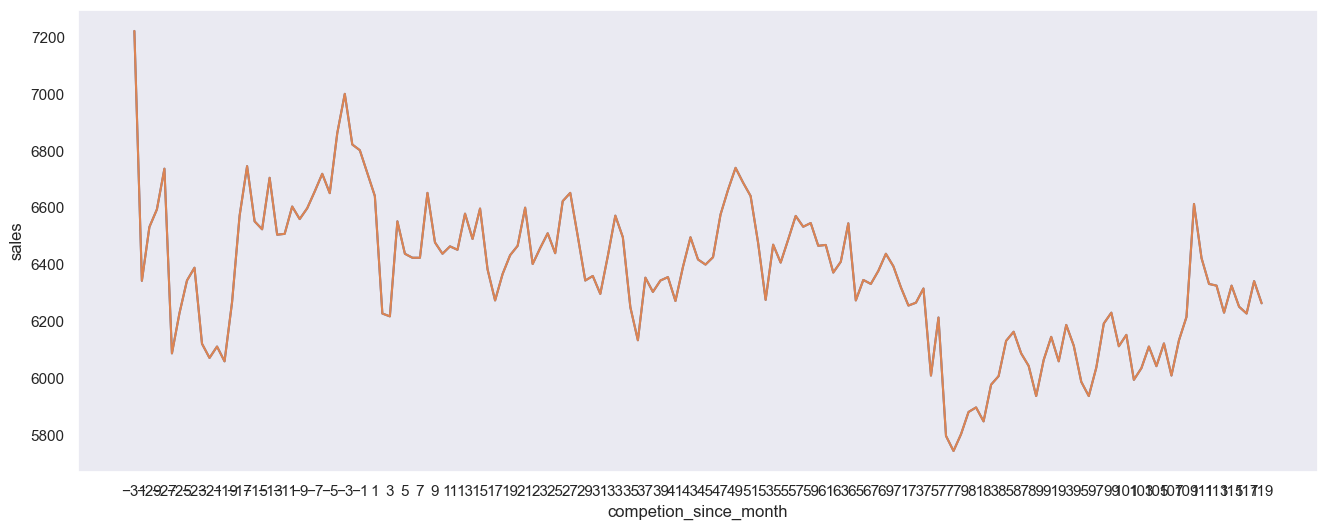

In [52]:
plt.figure(figsize = (16,6))

aux1['mediana'] = auxmediana['sales'].values
sns.lineplot(x = 'competion_since_month', y = 'sales', data = aux1)
sns.lineplot(x = 'competion_since_month', y = 'mediana', data = aux1)

num_ticks = 30

# Configurando os ticks no eixo x
plt.grid()
plt.xticks(np.arange(aux1.competion_since_month.min(), aux1.competion_since_month.max().max()+1,2));



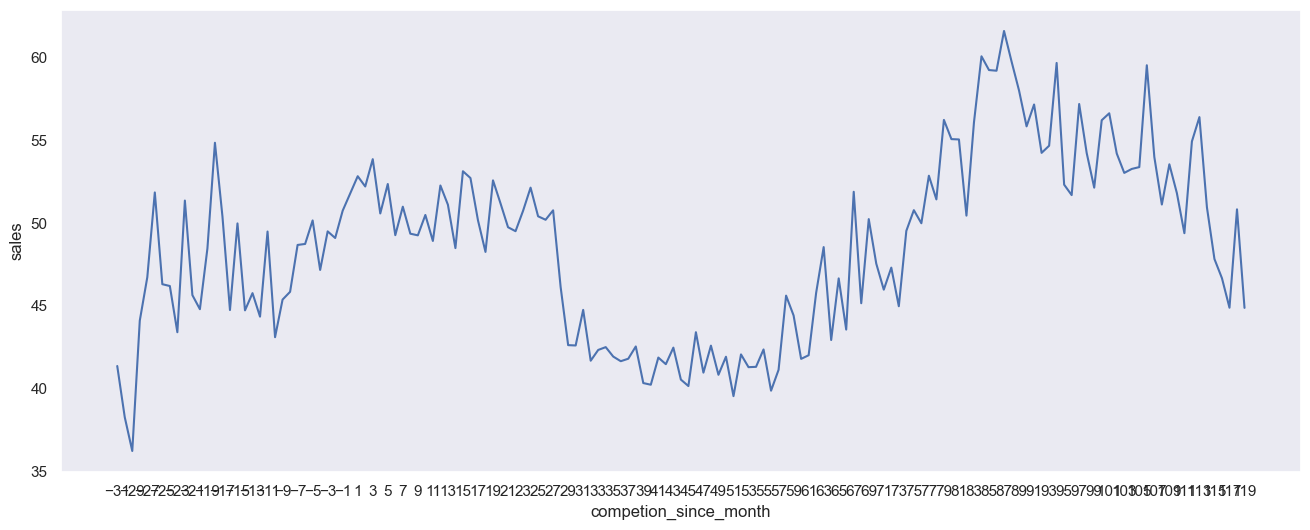

In [53]:
aux2  = df4.groupby(['competion_since_month']).agg({'sales' : 'std'}).reset_index()
aux2['sales'] = round(100 * aux2['sales']/aux1['sales'],2)

aux2 = aux2.loc[(aux2.competion_since_month < 120)]
aux2 = aux2.loc[aux2.competion_since_month != 0]
plt.figure(figsize = (16,6))

sns.lineplot(x = 'competion_since_month', y = 'sales', data = aux2)
num_ticks = 30

# Configurando os ticks no eixo x


# Configurando os ticks no eixo x
plt.grid()
plt.xticks(np.arange(aux1.competion_since_month.min(), aux1.competion_since_month.max().max()+1,2));



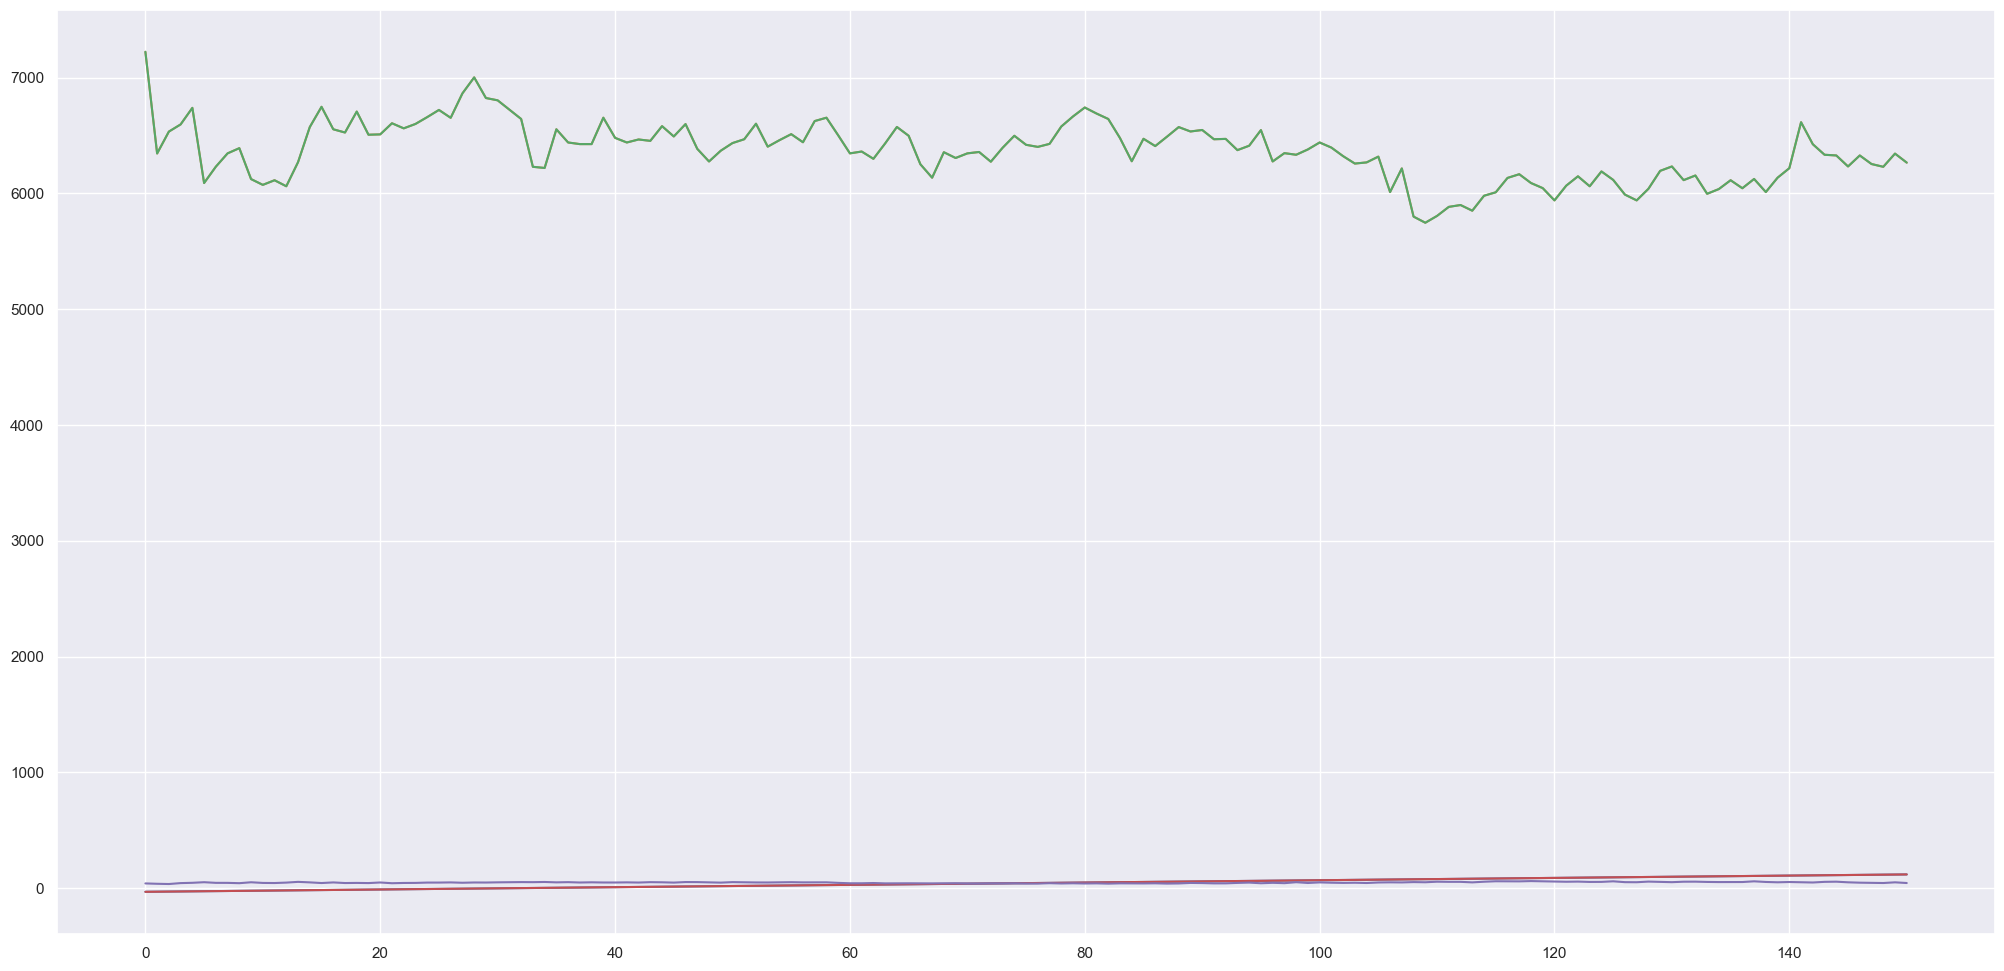

In [54]:
plt.plot(aux1)
plt.plot(aux2)


<Axes: xlabel='competion_since_month', ylabel='sales'>

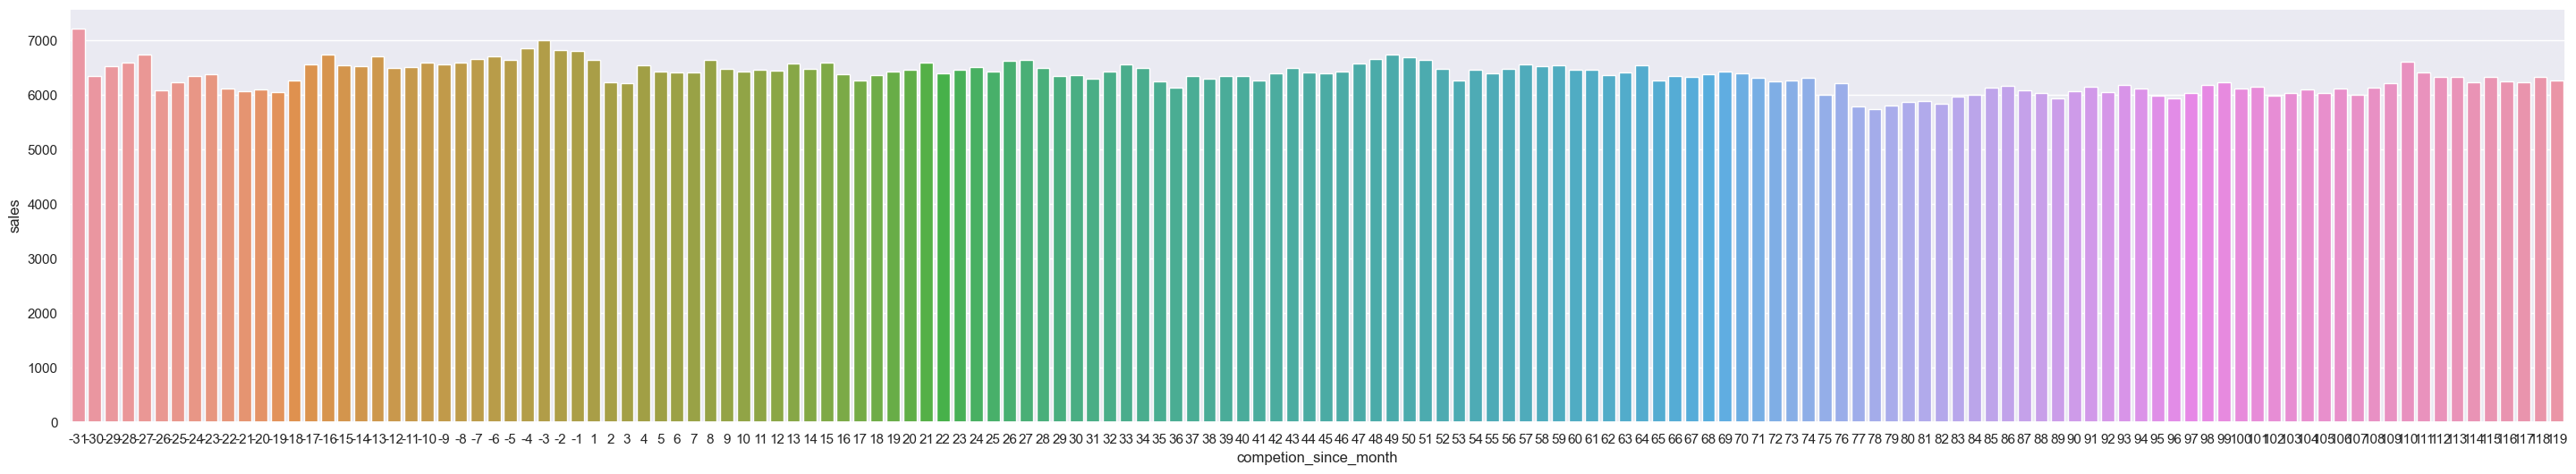

In [55]:
plt.figure(figsize = (36,6))

sns.barplot(x = 'competion_since_month', y = 'sales', data = aux1)


##### Conclusão

Hipotese é falsa. 
Lojas com competidores a mais tempo não vendem mais. 
Porém, lojas com competidores próximos de abrirem vendem mais
Lojas com competidores há muito tempo, vendem menos que lojas com competidores há menos tempo. 

Pode ser que, os competidores abriram antes das lojas da companhia, sendo então, a companhia a lutar pelo marketshare da região, e não o contrario, sendo este um possível motivo para esse comportamento

#### H4. Lojas com promoções do tipo 2 ativas há mais tempo, vendem mais (promoção extendida) 

**Falsa** O tempo de presença da promo2, não apresenta impacto no ticket médio das lojas. Com excessão do momento em que a promo2 é ativada  

Text(0.5, 1.0, 'Menor que zero')

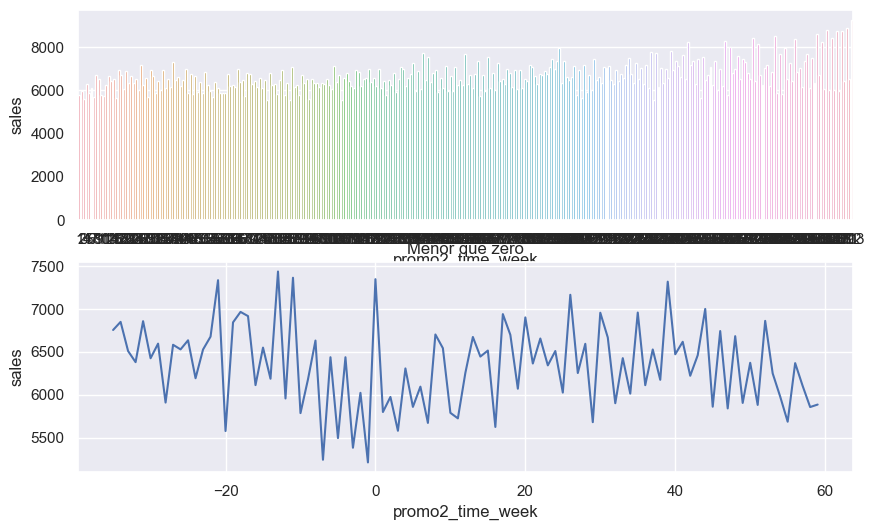

In [56]:
aux1 = df4[['promo2_time_week', 'sales']].groupby('promo2_time_week').mean().reset_index()

aux2 = aux1[aux1.promo2_time_week > 0]
aux3 = aux1[aux1.promo2_time_week < 0]

aux4 = aux1[(aux1.promo2_time_week > -36) & (aux1.promo2_time_week < 60)]


plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
sns.barplot(x = 'promo2_time_week', y = 'sales', data = aux2)

plt.subplot(2,1,2)
sns.lineplot(x = 'promo2_time_week', y = 'sales', data = aux4)
plt.title('Menor que zero')

O tempo de presença da promo2, não apresenta "grande" impacto no ticket médio das lojas 

##### E a existencia da promo2, impacta? 

<Axes: xlabel='status', ylabel='ticket_medio'>

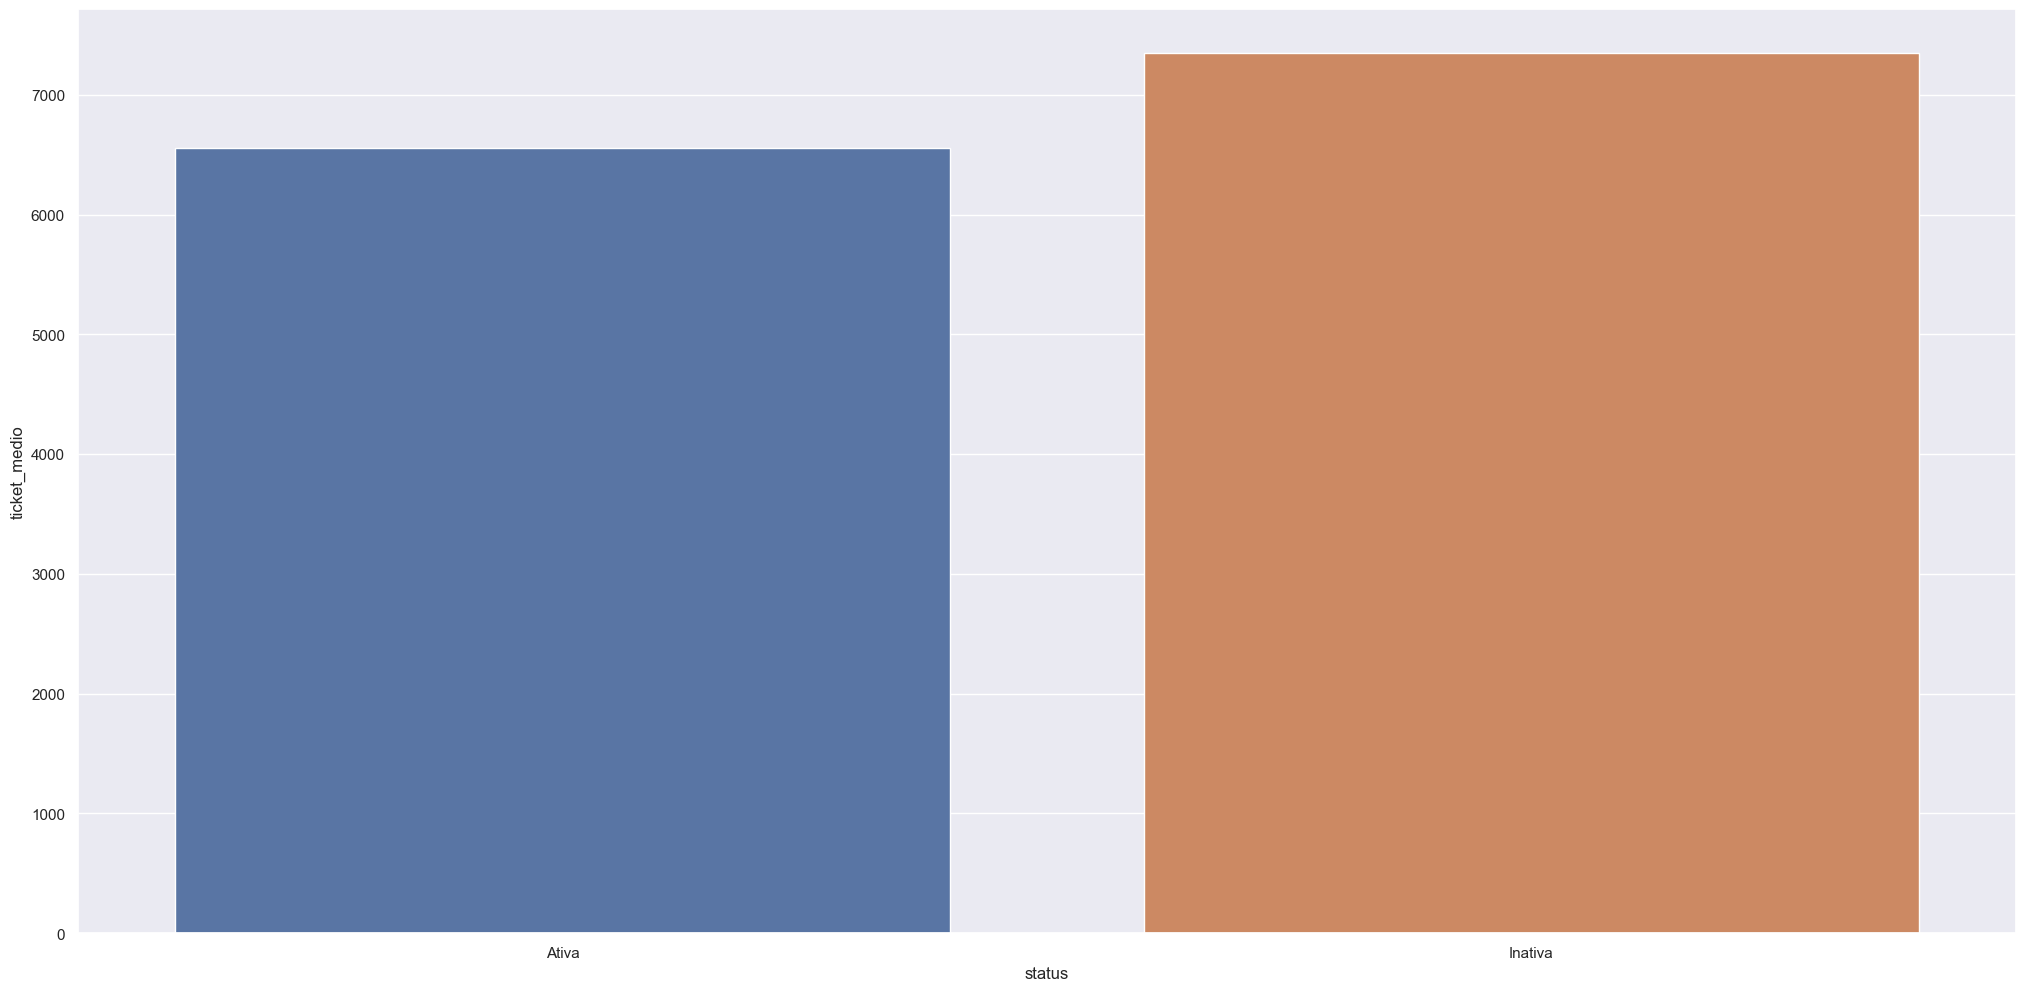

In [57]:
inativa = df4[df4.promo2 == 0].sales.mean()
ativa = df4[df4.promo2 == 1].sales.mean()
promo2_evaluate = pd.DataFrame(index = ['Ativa', 'Inativa'], columns = ['ticket_medio'])
promo2_evaluate['ticket_medio'] = [ativa, inativa]
promo2_evaluate['status'] = promo2_evaluate.index.values 

sns.barplot(x = 'status' , y = 'ticket_medio', data = promo2_evaluate)

**O ticket médio cai, quando a promo2 está ativa** 

In [58]:
df4.promo2.value_counts()

promo2
0    211578
1    210729
Name: count, dtype: int64

**E a promo 1? impacta no volume de vendas de uma loja**

<Axes: xlabel='promo', ylabel='sales'>

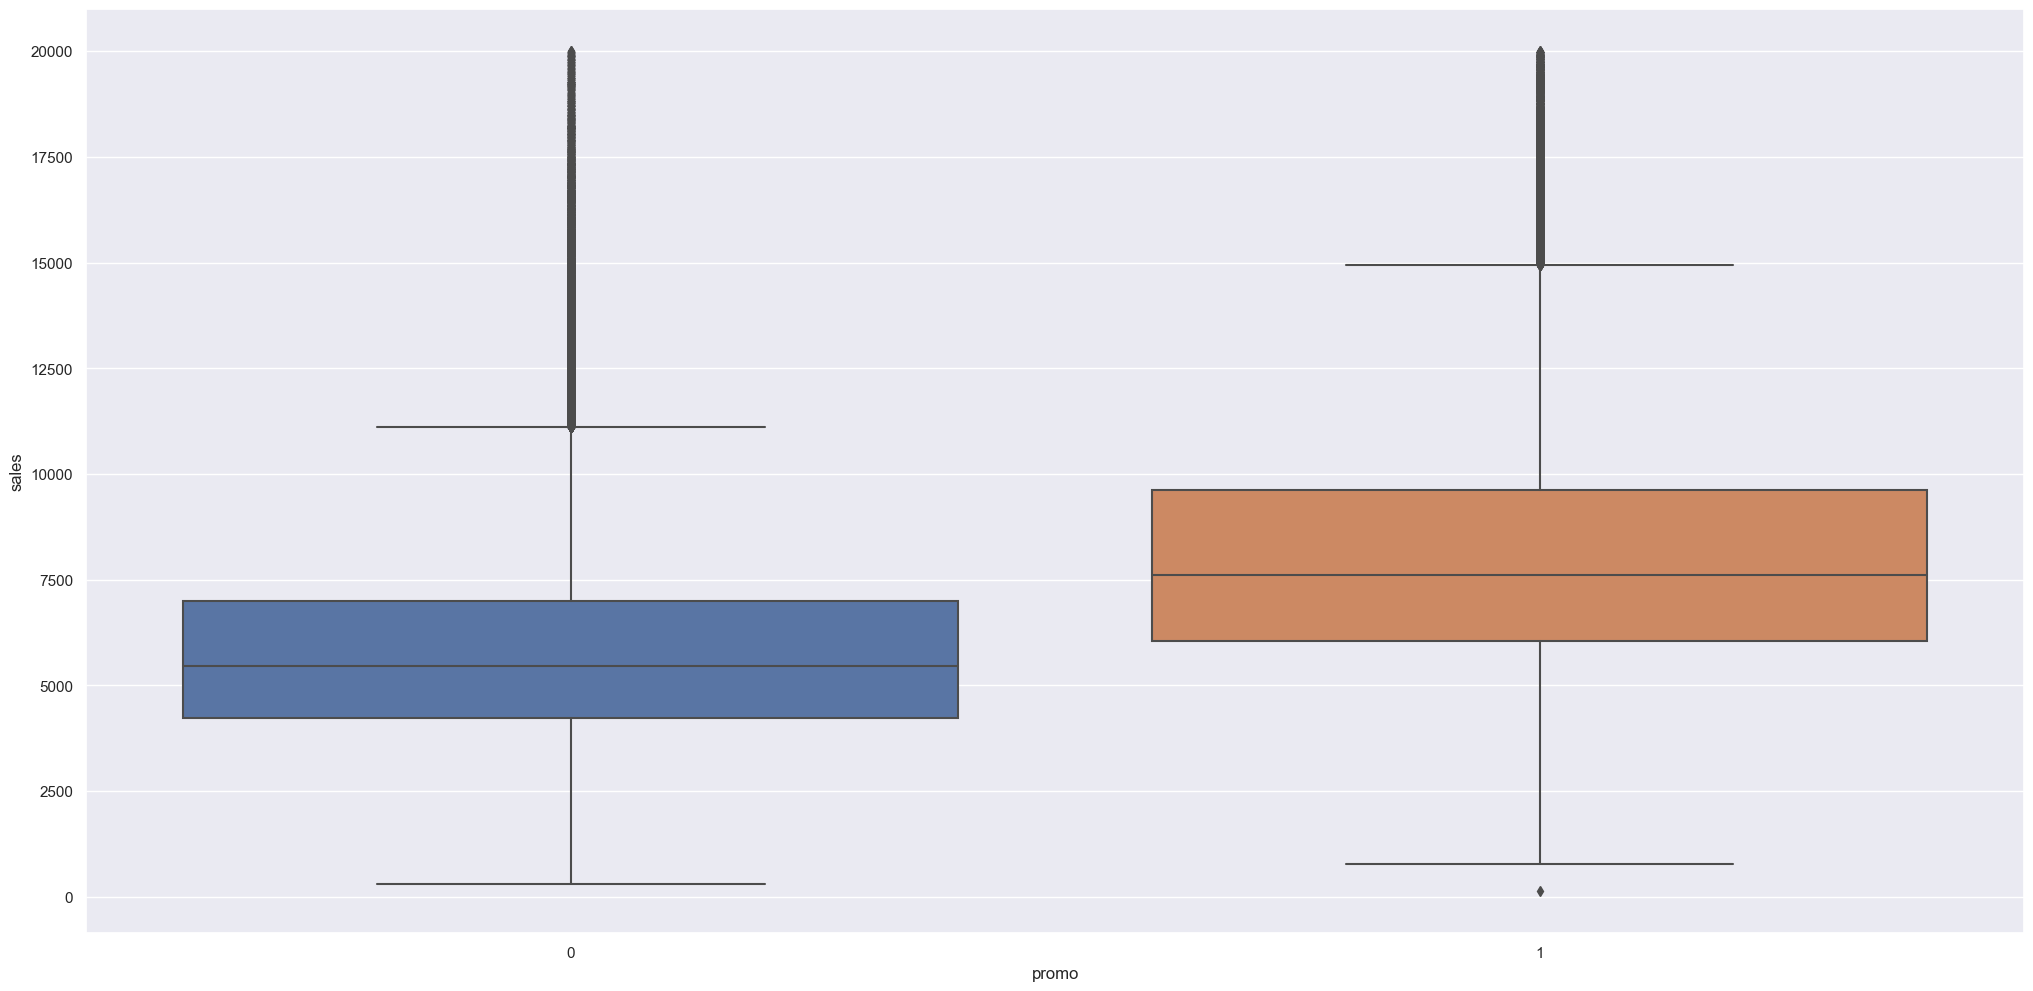

In [59]:
aux1 = df4[df4.sales < 20000]
sns.boxplot(x = 'promo', y = 'sales', data = aux1)

<Axes: xlabel='status', ylabel='ticket_medio'>

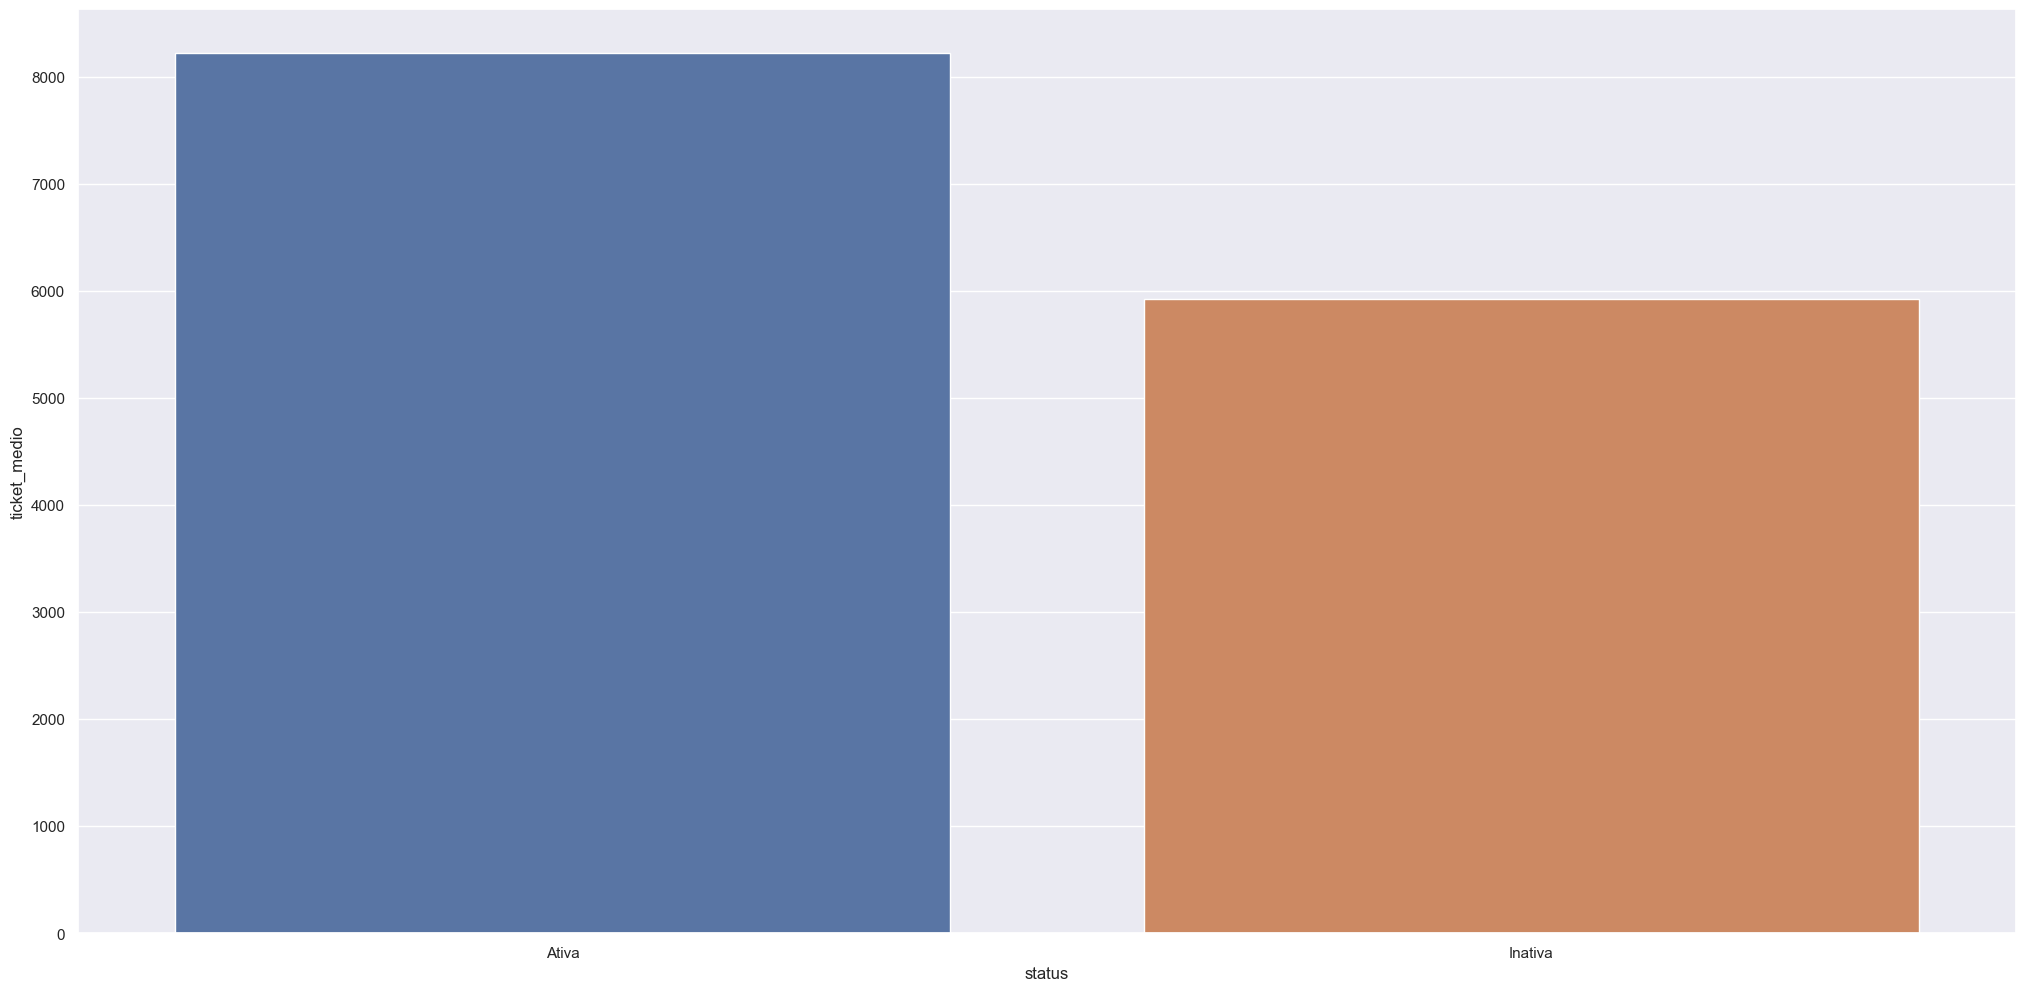

In [60]:
inativa = df4[df4.promo == 0].sales.mean()
ativa = df4[df4.promo == 1].sales.mean()
promo2_evaluate = pd.DataFrame(index = ['Ativa', 'Inativa'], columns = ['ticket_medio'])
promo2_evaluate['ticket_medio'] = [ativa, inativa]
promo2_evaluate['status'] = promo2_evaluate.index.values 

sns.barplot(x = 'status' , y = 'ticket_medio', data = promo2_evaluate)

In [61]:
df4.promo.value_counts()

promo
0    234093
1    188214
Name: count, dtype: int64

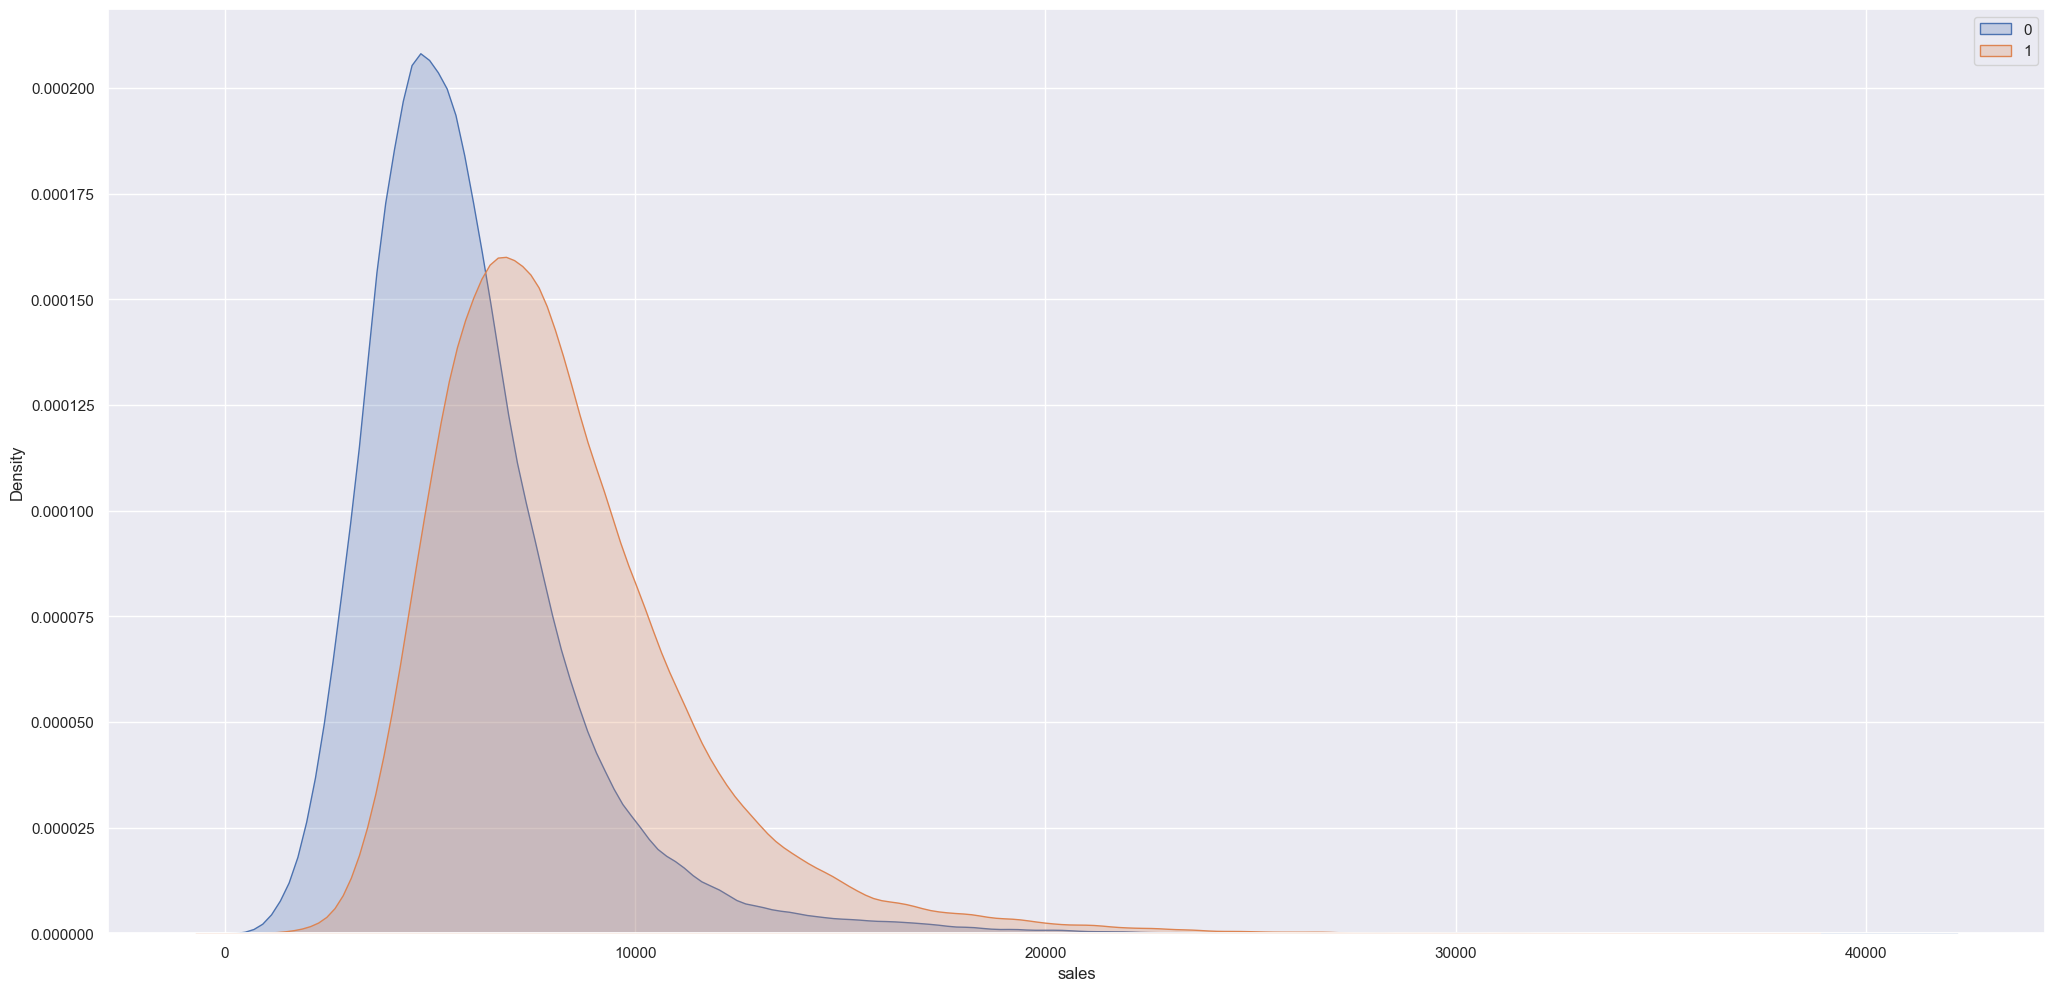

In [62]:
sns.kdeplot(df4[df4['promo'] == 0]['sales'], label = '0', fill = True)
sns.kdeplot(df4[df4['promo'] == 1]['sales'], label = '1', fill = True)
plt.legend()

A presença da promo1 aumenta a probabilidade de ocorrencia de vendas mais elevadas

Sim, a presenta da promo1, aumenta significativa o ticket médio de uma loja, elevando a mediana de aproximadamente 6k para proximo de 8

#### H8. No feriado de natal, as lojas vendem mais

**Verdadeira**

O valor do ticket médio no feriado de natal, é superior ao ticket médio dos demais dias. 

In [63]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'promo_interval',
       'date_month', 'is_promo', 'year', 'month', 'day', 'week_year',
       'year_week', 'competion_since_days', 'competion_since_month',
       'promo2_since', 'promo2_time_week'],
      dtype='object')

In [65]:
aux1 = df4[['state_holiday', 'sales']].groupby(['state_holiday']).mean().reset_index()
sns.boxplot(x = 'state_holiday', y = 'sales', data = df4)

KeyboardInterrupt: 

<Axes: xlabel='state_holiday', ylabel='sales'>

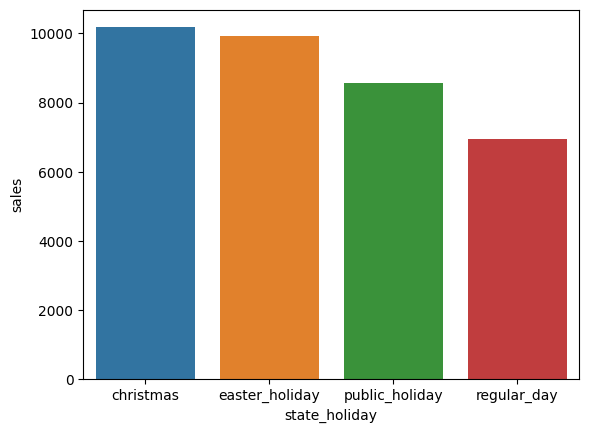

In [ ]:
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1)

#### H9. Lojas vendem mais ao longo dos anos 

**Falsa** As vendas estão caindo ao longo dos anos




In [ ]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'promo_interval',
       'date_month', 'is_promo', 'year', 'month', 'day', 'week_year',
       'year_week', 'competion_since_days', 'competion_since_month',
       'promo2_since', 'promo2_time_week'],
      dtype='object')

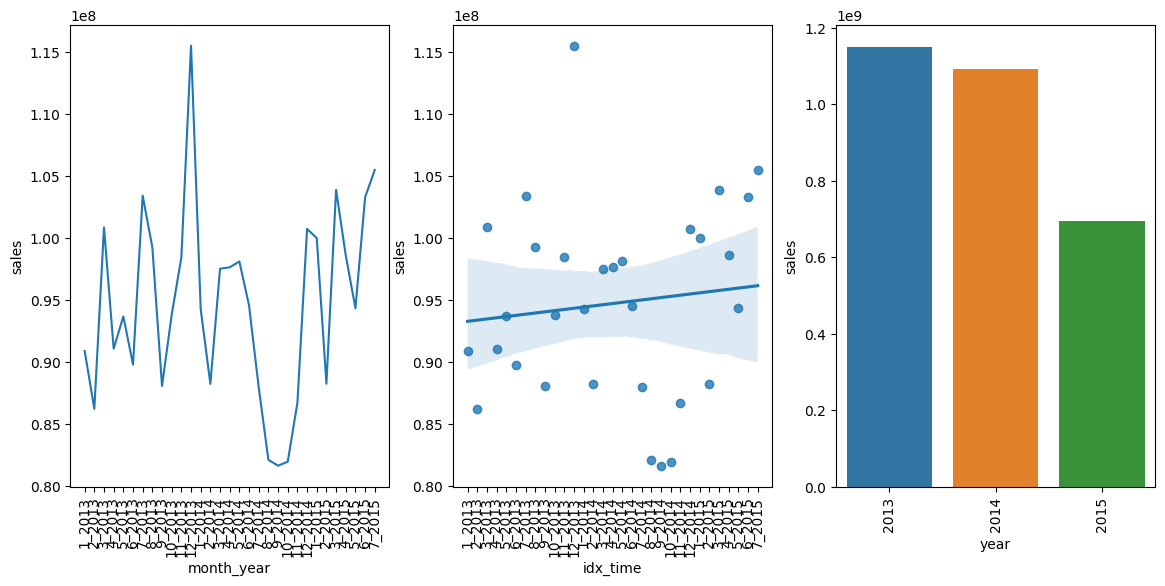

In [ ]:
aux1 = df4[['year', 'month', 'sales']].groupby(['year', 'month']).sum().reset_index()
aux1['month_year'] = aux1.apply(lambda x: str(x['month']) + '_' + str(x['year']), axis = 1)
aux1 = aux1.sort_values(by = ['year', 'month'])
plt.figure(figsize = (14,6))
plt.subplot(1,3,1)
plt.xticks(rotation = 90);
sns.lineplot(x = 'month_year', y = 'sales', data = aux1)



aux1['idx_time'] = [x for x in range(len(aux1))]
plt.subplot(1,3,2)
sns.regplot(x = 'idx_time', y = 'sales', data = aux1)
plt.xticks(ticks = aux1['idx_time'], labels = aux1['month_year'], rotation = 90);


plt.subplot(1,3,3)
aux1 = df4[['year', 'sales']].groupby(['year']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', data = aux1)
plt.xticks(rotation = 90);
plt.show()

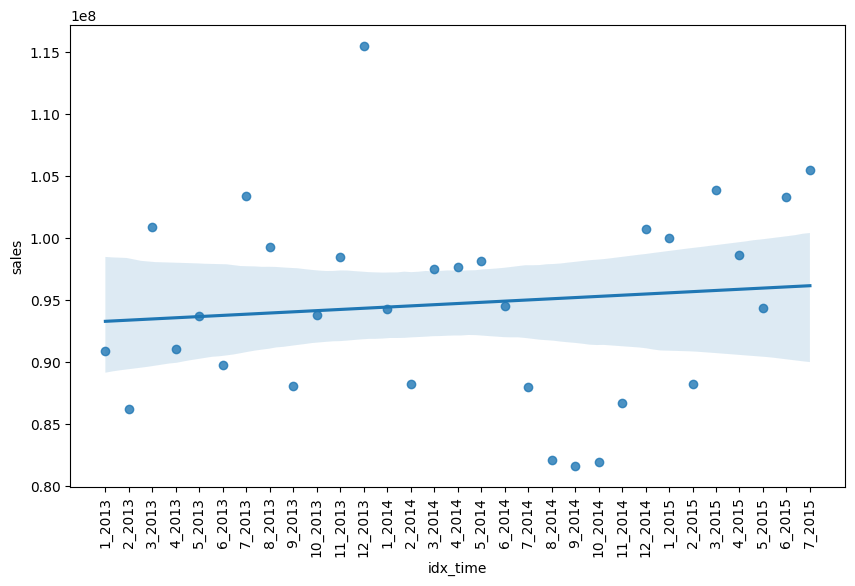

In [ ]:
aux1['idx_time'] = [x for x in range(len(aux1))]
plt.figure(figsize=(10,6))
sns.regplot(x = 'idx_time', y = 'sales', data = aux1)
plt.xticks(ticks = aux1['idx_time'], labels = aux1['month_year'], rotation = 90);
plt.show()



In [ ]:
aux1[['idx_time','sales']].corr()

,idx_time,sales
idx_time,1.000000,0.111813
sales,0.111813,1.000000


#### H10. O faturamento da Rossman é maior no segundo semestre de cada ano
**False:** The sales volume in the sencond half of the year is pratically the same of the first half of the year

<Axes: xlabel='semestre', ylabel='sales'>

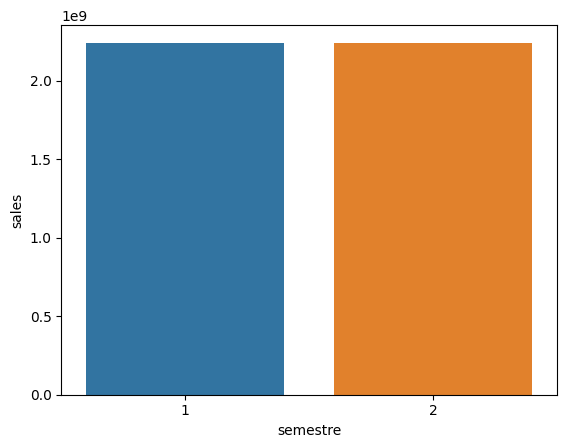

In [ ]:
aux1 = df1[df1.date.dt.year < 2015].copy()

aux1months = aux1.date.dt.month 
aux1['semestre'] = np.where(aux1months < 7, 1, 2)
aux2 = aux1[['semestre', 'sales']].groupby('semestre').sum().reset_index()
sns.barplot(x = 'semestre', y = 'sales', data = aux2)

In [ ]:
aux2

,semestre,sales
0,1,2241374300
1,2,2242306680


##### H10.1 - O ticket médio das lojas é maior no segundo semestre

**Verdadeiro:** O ticket médio das lojas no segundo semestre, é superior ao primeiro MAAASS, o volume total de vendas é inferior

<Axes: xlabel='semestre', ylabel='sales'>

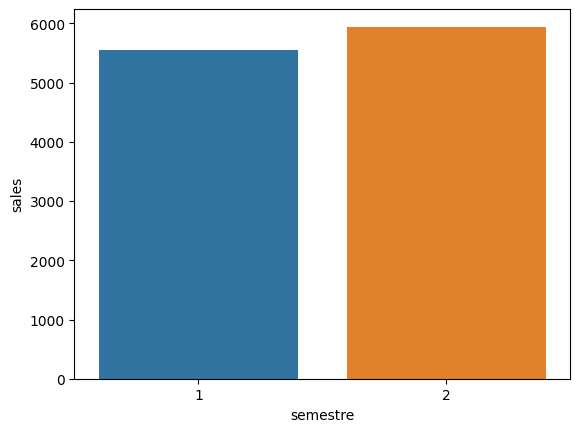

In [ ]:
aux2 = aux1[['semestre', 'sales']].groupby('semestre').mean().reset_index()
sns.barplot(x = 'semestre', y = 'sales', data = aux2)

In [ ]:
aux2

,semestre,sales
0,1,5553.055653
1,2,5944.609438


#### H11. Lojas vendem mais depois do dia 10 de cada mes. 
**Falsa**. O faturamento total da Rossman é maior sim, nos ultimos 20 dias, porém é possível dizer que o valor de venda médio das lojas não sem alteram dos primeiros 10 para os ultimos 20 dias, ou em outras palavras. O momento do mês parece pouco influcenciar no valor das vendas

<Axes: xlabel='threshold_month', ylabel='sales'>

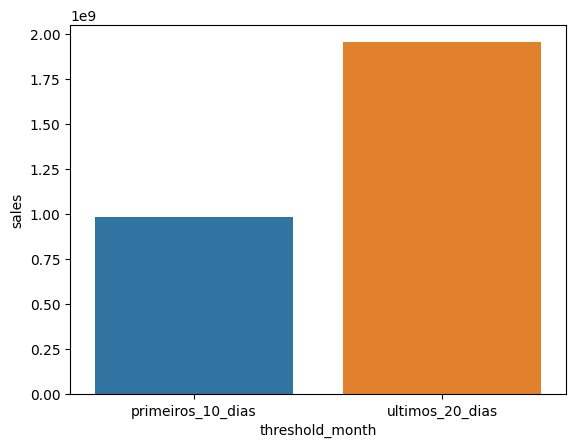

In [ ]:
aux1 = df4.copy()

aux1days = aux1.date.dt.day 
aux1['threshold_month'] = np.where(aux1days < 11, 'primeiros_10_dias', 'ultimos_20_dias')
aux2 = aux1[['threshold_month', 'sales']].groupby('threshold_month').sum().reset_index()
sns.barplot(x = 'threshold_month', y = 'sales', data = aux2)

<Axes: xlabel='threshold_month', ylabel='sales'>

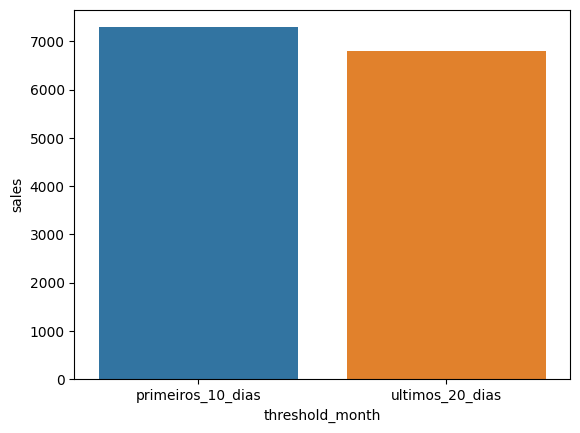

In [ ]:
aux1 = df4.copy()

aux1days = aux1.date.dt.day 
aux1['threshold_month'] = np.where(aux1days < 11, 'primeiros_10_dias', 'ultimos_20_dias')
aux2 = aux1[['threshold_month', 'sales']].groupby('threshold_month').mean().reset_index()
sns.barplot(x = 'threshold_month', y = 'sales', data = aux2)

<Axes: xlabel='threshold_month', ylabel='sales'>

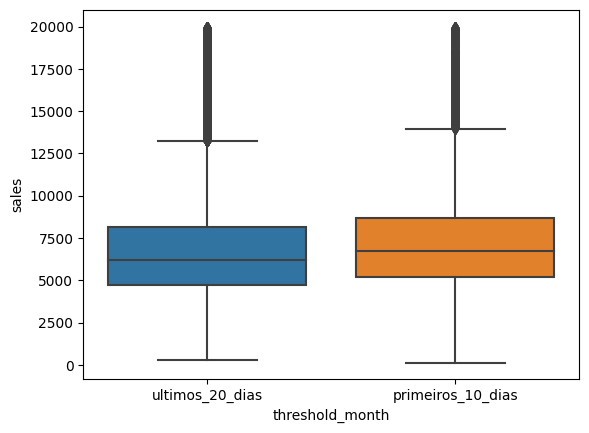

In [ ]:
aux2 = aux1[['threshold_month', 'sales']]
sns.boxplot(x = 'threshold_month', y = 'sales', data = aux2[aux2.sales < 20000])


In [ ]:
aux2.sales.min()

0

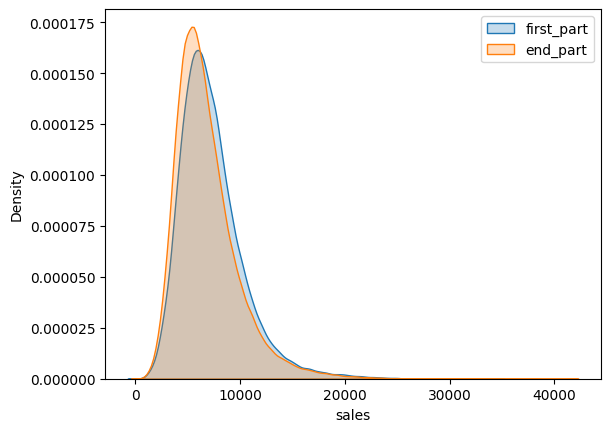

In [ ]:
sns.kdeplot(aux2[aux2.threshold_month == 'primeiros_10_dias']['sales'], label = 'first_part', fill = True)
sns.kdeplot(aux2[aux2.threshold_month == 'ultimos_20_dias']['sales'], label = 'end_part', fill = True)
plt.legend()

#### H13. Lojas vendem menos durante feriados escolares 
**Falsa** Nos feriados escolares as vendas praticamente não se alteram, porém há uma pequena elevação no ticket médio das lojas em dias de feriados escolares

<Axes: xlabel='school_holiday', ylabel='sales'>

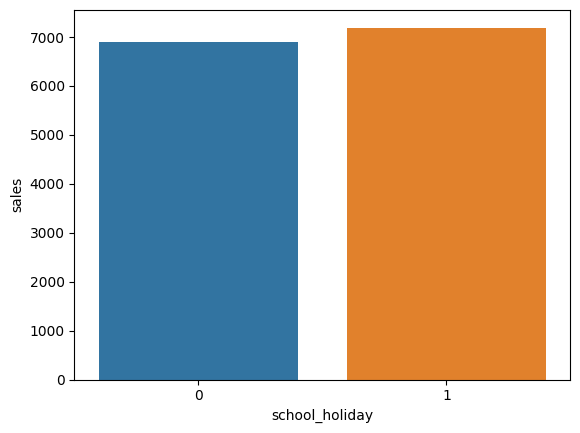

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby(['school_holiday']).mean().reset_index()
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1)

<Axes: xlabel='school_holiday', ylabel='sales'>

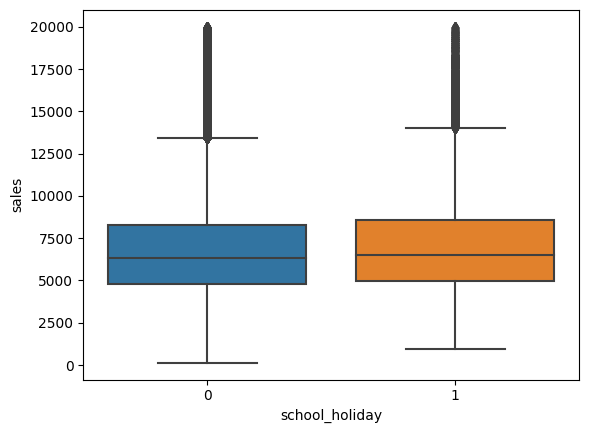

In [ ]:
sns.boxplot(x = 'school_holiday', y = 'sales', data = df4[df4.sales < 20000])

### 4.3 Análise Multivariada

#### 4.3.1 - Numerical Attributes

<Axes: >

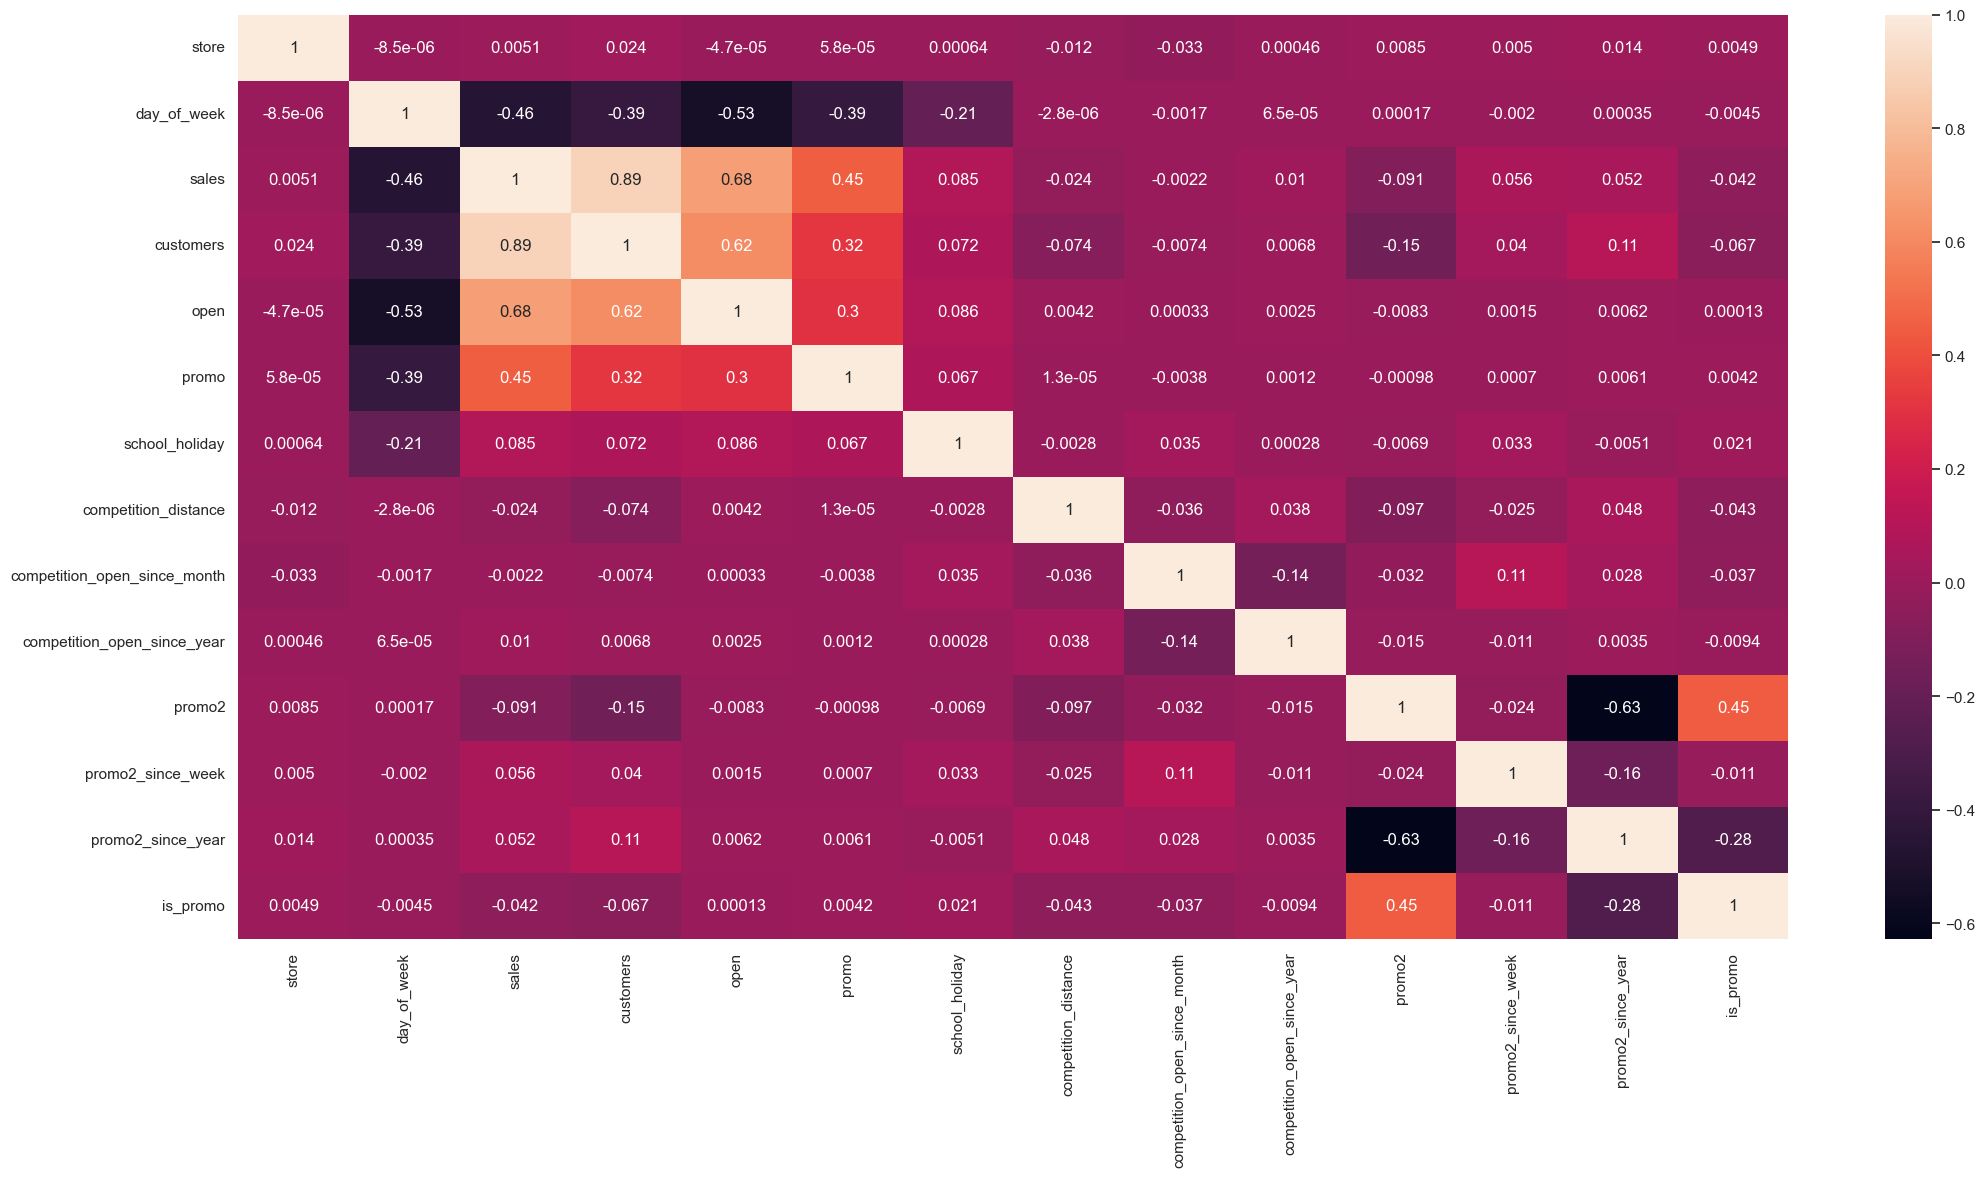

In [ ]:
correlation = num_attributes.corr() 
#plt.figure(figsize = (16,7.5))
sns.heatmap(correlation, annot = True)

#### 4.3.2 - Categorical Attributes

In [ ]:
cat_attributes = df4.select_dtypes('object')
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,date_month,year_week
0,regular_day,c,basic,0,Jul,2015-30
3,regular_day,c,etended,0,Jul,2015-30
5,regular_day,a,basic,0,Jul,2015-30
8,regular_day,a,etended,0,Jul,2015-30
9,regular_day,a,basic,0,Jul,2015-30


**Teste Crammer V**

<Axes: >

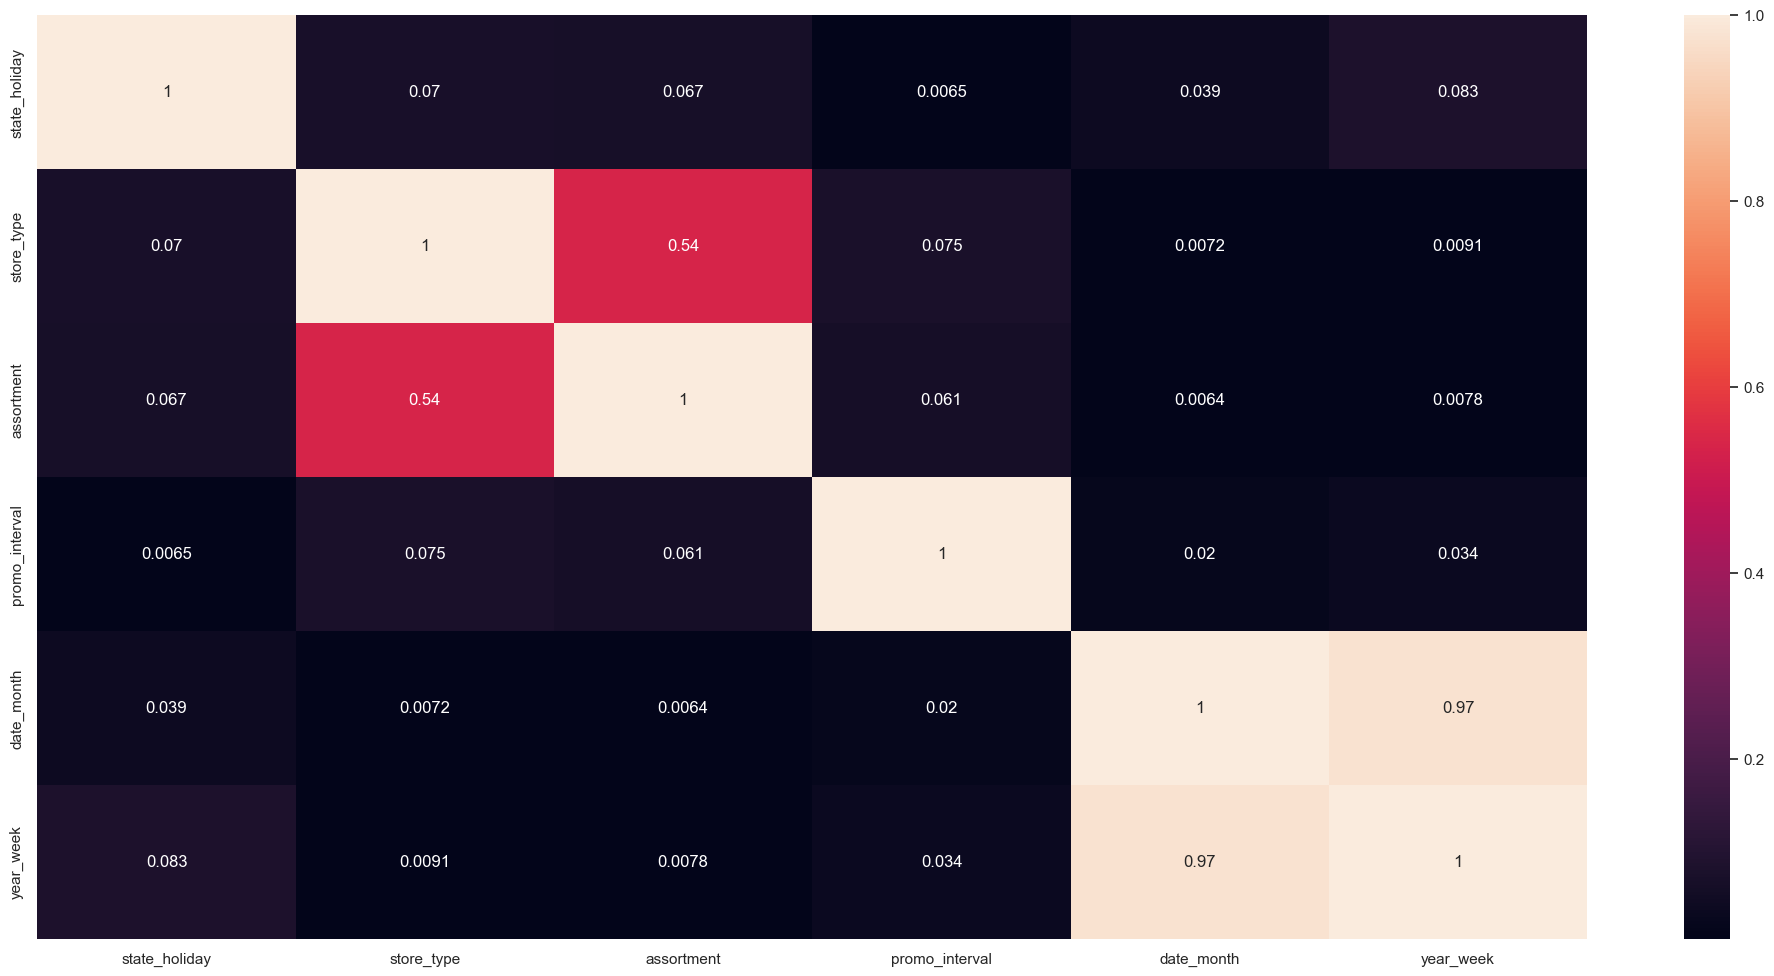

In [ ]:

def generate_heatmap( cat_attribute_names : list):
    results = {}
    for item in cat_attribute_names:
        resultados = []
        for subitem in cat_attribute_names:
            resultados.append(crammer_v(cat_attributes, item, subitem))    
        
        results[item] = resultados  
    
    
    result = pd.DataFrame(data = results, index = [x for x in cat_attribute_names])
    return result 
    
sns.heatmap(generate_heatmap(cat_attributes.columns.values), annot=True)

# # Exportando Resultado

In [ ]:
df4.to_parquet('./dfs/df5_init.parquet')